In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

# packages for models
import sklearn
from sklearn.svm import SVC
import skelm 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from xgboost import XGBClassifier

# dimensionality reduction
from sklearn.decomposition import PCA
from featurewiz import featurewiz

# import own functions
from ipynb.fs.full.Functions import load_train_test_data, model_eval, run_gridsearchCV, load_model, feature_importance

pd.set_option('display.max_columns', None)
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

Imported 0.2.8 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



# RBF-SVM with 1-1 
## Only 6 parameters
According to paper 4: Luengo et al. (2005). "Automatic Emotion Recognition using Prosodic Parameters"

In [2]:
# load the data
df = pd.read_pickle('../results/df_prep_numerical_only.pkl')
df.columns

Index(['duration', 'mean', 'median', 'max', 'min', 'var', 'std',
       'speaking_rate', 'articulation_rate', 'asd',
       ...
       'lpc_local2_min', 'lpc_local3_mean', 'lpc_local3_var', 'lpc_local3_max',
       'lpc_local3_min', 'lpc_local4_mean', 'lpc_local4_var', 'lpc_local4_max',
       'lpc_local4_min', 'label'],
      dtype='object', length=270)

In [3]:
# selection of features (mean pitch, mean energy, pitch variance, skew of logarithmic pitch, range of logarithmic pitch,
# range of logarithmic energy)
df6param = df[['label','pitch_mean', 'pitch_var', 'energy_mean', 'skew_log_pitch', 'range_log_pitch', 'range_log_energy']].copy()
df6param.head()

label  pitch_mean  pitch_var  energy_mean  skew_log_pitch  range_log_pitch  \
0      4   -0.741135  -0.527264    -0.181987       -0.296694        -0.600449   
1      5   -1.386939  -1.070989     0.237872       -0.198081        -1.185553   
2      0   -0.448158  -0.159707     0.165869       -0.030373        -0.662848   
3      4    0.445340   0.432260     0.621608       -0.401886        -0.186604   
4      5   -1.177707  -1.082482     1.031302       -0.559679        -1.360023   

   range_log_energy  
0          0.125001  
1          0.125309  
2          0.131056  
3          0.114911  
4          0.112277

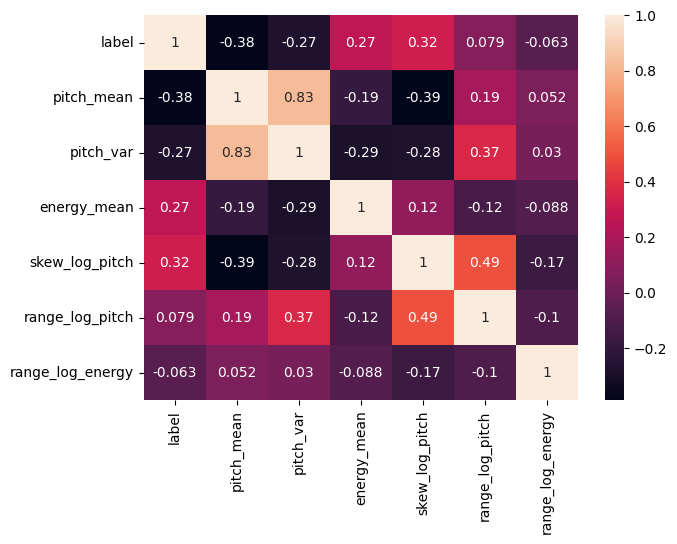

In [4]:
# look at the correlation of the data
plt.figure(figsize=(7,5))
sns.heatmap(df6param.corr(), annot=True)
plt.show()

We can see that *pitch_var* and *pitch_mean* show a highly positive correlation. *skew_log_pitch* and *range_log_pitch* are also positively correlated. 
Nevertheless, we also see that the features are not highly correlated with the target class which means they are not as useful for a model.

In [5]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df6param)

A snippet of the data:


pitch_mean  pitch_var  energy_mean  skew_log_pitch  range_log_pitch  \
241   -1.455074  -1.205638     1.184469       -0.294200        -1.483766   
364   -0.605954  -0.620878    -1.575339        0.617414         1.926389   
209   -0.629998  -0.598067    -1.598139        0.587535         0.091817   
430    0.611862   0.207716    -0.070193       -0.201563        -0.204404   
309    0.686027   0.723976     0.775073       -0.145928        -0.511626   

     range_log_energy  
241         -0.154248  
364          0.103658  
209          0.130748  
430          0.130406  
309          0.113201

There are 454 entries with 6 columns in the training data.
There are 81 entries with 6 columns in the testing data.


In [6]:
# compare statistics of these features per class
df6param.groupby('label').describe()

pitch_mean                                                              \
           count      mean       std       min       25%       50%       75%   
label                                                                          
0          127.0  0.689696  0.854154 -1.237117  0.098010  0.611862  1.220455   
1           81.0 -0.418604  0.613830 -1.466965 -1.004980 -0.254267  0.011152   
2           46.0 -0.171051  0.570315 -1.433670 -0.550613 -0.231479  0.301762   
3           69.0  0.156168  0.905825 -1.292712 -0.561537  0.012939  0.833352   
4           71.0  0.857590  0.959226 -1.001188  0.122822  0.840894  1.622096   
5           79.0 -0.617371  0.592247 -1.718260 -1.132451 -0.670270 -0.078147   
6           62.0 -1.108198  0.489678 -1.727773 -1.415668 -1.271766 -0.958159   

                pitch_var                                                    \
            max     count      mean       std       min       25%       50%   
label                                                                         
0      3.073941     127.0  0.715384  1.002463 -0.734068 -0.114924  0.563750   
1      0.731029      81.0 -0.701570  0.398769 -1.286442 -1.102002 -0.621115   
2      0.842627      46.0 -0.112042  0.537014 -1.076268 -0.401498 -0.062020   
3      2.127298      69.0  0.026308  0.794564 -1.132244 -0.623900  0.008392   
4      2.748186      71.0  0.846796  1.041707 -0.878306  0.027648  0.663345   
5      0.370440      79.0 -0.715391  0.422773 -1.284550 -1.109559 -0.750694   
6      0.539803      62.0 -0.553137  0.747083 -1.216611 -0.975058 -0.706568   

                          energy_mean                                          \
            75%       max       count      mean       std       min       25%   
label                                                                           
0      1.339874  3.232342       127.0 -0.529843  0.841799 -2.334219 -1.230734   
1     -0.408837  0.225256        81.0  0.012130  0.848196 -1.835554 -0.597045   
2      0.228115  1.705332        46.0 -0.142168  1.045840 -1.728615 -0.933925   
3      0.532507  2.007656        69.0  0.479938  0.956554 -1.681293 -0.286071   
4      1.777960  3.583298        71.0 -0.219051  0.904318 -1.920062 -0.953045   
5     -0.371378  0.366171        79.0  0.688053  0.953717 -1.088775  0.017811   
6     -0.453697  2.515015        62.0  0.014969  0.951420 -1.822611 -0.711565   

                                    skew_log_pitch                      \
            50%       75%       max          count      mean       std   
label                                                                    
0     -0.609235 -0.001773  1.882095          127.0 -0.539033  0.476105   
1     -0.005991  0.614168  1.947731           81.0  0.343137  0.690881   
2     -0.172431  0.518771  2.649275           46.0 -0.183320  0.892751   
3      0.418388  1.107696  2.930019           69.0 -0.011670  0.917714   
4     -0.130040  0.380397  1.794269           71.0 -0.445320  0.385847   
5      0.501303  1.312020  2.895989           79.0  0.082190  0.974325   
6     -0.020992  0.570391  2.699426           62.0  1.210093  1.500035   

                                                        range_log_pitch  \
            min       25%       50%       75%       max           count   
label                                                                     
0     -1.534939 -0.866976 -0.506416 -0.222557  0.861475           127.0   
1     -1.022515 -0.080791  0.212575  0.591289  2.979251            81.0   
2     -2.194094 -0.812821 -0.135425  0.342518  1.821081            46.0   
3     -1.388781 -0.530163 -0.192745  0.251145  3.182031            69.0   
4     -1.412852 -0.688763 -0.457764 -0.200277  0.276181            71.0   
5     -1.726307 -0.470560 -0.198081  0.234643  3.001234            79.0   
6     -1.085911  0.025810  0.825909  2.434594  4.915461            62.0   

                                                                             \
           mean       std       

In [6]:
svm_model = SVC(kernel='rbf', C=1, gamma=0.1, class_weight='balanced', decision_function_shape='ovo')
svm_model.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', decision_function_shape='ovo', gamma=0.1)


Evaluation: f1_score
54.62% for the train data
45.24% for the test data

Evaluation: accuracy_score
55.95% for the train data
48.15% for the test data

Evaluation: precision_score
57.07% for the train data
47.20% for the test data

Evaluation: recall_score
55.09% for the train data
48.13% for the test data

Evaluation: confusion_matrix of test predictions


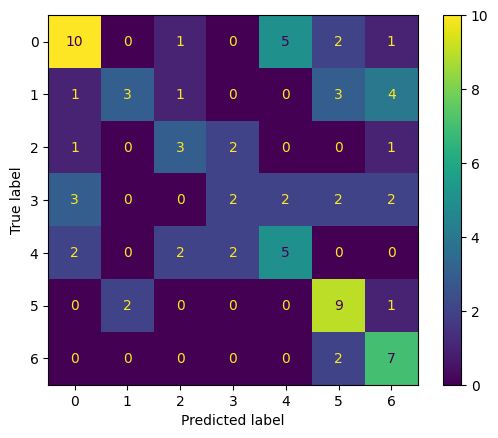


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)', 'sadness(6)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']
Hard cases of false positives: ['happiness(4)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['disgust(2)', 'happiness(4)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['boredom(1)']



In [8]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

A snippet of the data:


pitch_mean  energy_mean  range_log_pitch  range_log_energy
241   -1.455074     1.184469        -1.483766         -0.154248
364   -0.605954    -1.575339         1.926389          0.103658
209   -0.629998    -1.598139         0.091817          0.130748
430    0.611862    -0.070193        -0.204404          0.130406
309    0.686027     0.775073        -0.511626          0.113201

There are 454 entries with 4 columns in the training data.
There are 81 entries with 4 columns in the testing data.

Evaluation: f1_score
40.52% for the train data
31.60% for the test data

Evaluation: accuracy_score
42.51% for the train data
34.57% for the test data

Evaluation: precision_score
40.85% for the train data
32.98% for the test data

Evaluation: recall_score
40.81% for the train data
33.25% for the test data

Evaluation: confusion_matrix of test predictions


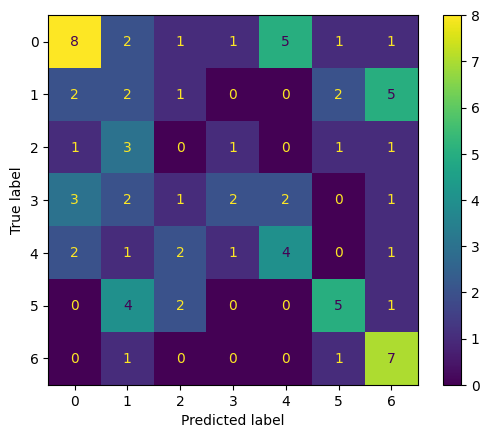


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['sadness(6)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['happiness(4)', 'neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']

Label: sadness(6)
Hard cases of false positives: ['boredom(1)']



In [9]:
# drop correlated features and run again
df6param_uncor = df6param.drop(columns=['pitch_var', 'skew_log_pitch'])
# Load the train/test data
X_train_uncor, X_test_uncor, y_train_uncor, y_test_uncor = load_train_test_data(df6param_uncor)
svm_model.fit(X_train_uncor, y_train_uncor)
model_eval(svm_model, X_train_uncor, X_test_uncor, y_train_uncor, y_test_uncor, confusion=True)

Actually performs worse when dropping these features. 
Next, we try to boost this very simple model with a gridsearch.

### Hyperparameter Optimization

In [10]:
# define the grid for the hyperparameter search
grid_vals = { 'C': [0.01, 0.1, 1, 10], 
            'gamma': [0.01, 0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'class_weight': ['balanced', None], 
            'decision_function_shape': ['ovo', 'ovr']
            }
run_gridsearchCV(svm_model, grid_vals, X_train, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_we

[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=poly; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=poly; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linea

[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.4s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.1s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.4s
[CV] 

[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=poly; total time=   0.1s
[CV] END C=0.01, class_weight=None, 

[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.2s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.1s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.2s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.1s
[CV] END C=0.01, class_weight=None, decisi

[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV]

[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   

[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight

[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=No

[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C

[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class

[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shap

[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shap

[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.1s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.1s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.1s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.2s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, c

[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.2s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.1s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.1s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.2s
[CV] END C=10, class_weight=bala

[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.1s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.1s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.1s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=

[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.2s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.2s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.2s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.1s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=


Evaluation: f1_score
51.11% for the train data
43.39% for the test data

Evaluation: accuracy_score
51.54% for the train data
44.44% for the test data

Evaluation: precision_score
51.58% for the train data
44.66% for the test data

Evaluation: recall_score
52.37% for the train data
45.83% for the test data

Evaluation: confusion_matrix of test predictions


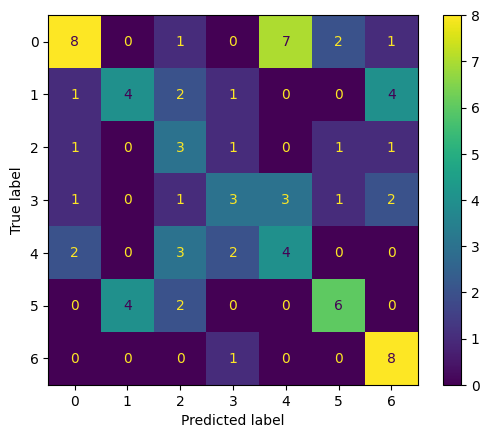


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['sadness(6)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false positives: ['happiness(4)']

Label: fear(3)
Hard cases of false negatives: ['happiness(4)']
Hard cases of false positives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['disgust(2)']
Hard cases of false positives: ['anger(0)', 'fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']

Label: sadness(6)
Hard cases of false positives: ['boredom(1)']



In [11]:
svm_best_model = load_model('SVC', 'f1_macro')
model_eval(svm_best_model,X_train, X_test, y_train, y_test, confusion=True)

# SVM 
###  Shen et al. (2011) "Automatic Speech Emotion Recognition Using Support Vector Machine" (Paper 3)

In [6]:
# load the data
df = pd.read_pickle('../results/df_prep_numerical_only.pkl')
df.columns

Index(['duration', 'mean', 'median', 'max', 'min', 'var', 'std',
       'speaking_rate', 'articulation_rate', 'asd',
       ...
       'lpc_local2_min', 'lpc_local3_mean', 'lpc_local3_var', 'lpc_local3_max',
       'lpc_local3_min', 'lpc_local4_mean', 'lpc_local4_var', 'lpc_local4_max',
       'lpc_local4_min', 'label'],
      dtype='object', length=270)

In [7]:
# selection of features: 
# energy features (19-dim), pitch features (19-dim), LPCCs (48-dim), MFCCs (52-dim), LPCMFCCs (48-dim) 
# -> 186 features + label
df_3 = df.filter(regex='energy_|pitch_|lpccs_|^mfccs|lpcmfccs_|label')
df_3.columns

Index(['energy_max', 'energy_mean', 'energy_var', 'energy_rising_duration_max',
       'energy_rising_duration_mean', 'energy_rising_duration_median',
       'energy_rising_duration_iqr', 'energy_falling_duration_max',
       'energy_falling_duration_mean', 'energy_falling_duration_median',
       ...
       'lpcmfccs_local9_min', 'lpcmfccs_local10_mean', 'lpcmfccs_local10_var',
       'lpcmfccs_local10_max', 'lpcmfccs_local10_min', 'lpcmfccs_local11_mean',
       'lpcmfccs_local11_var', 'lpcmfccs_local11_max', 'lpcmfccs_local11_min',
       'label'],
      dtype='object', length=187)

In [6]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3)

A snippet of the training data:


energy_max  energy_mean  energy_var  energy_rising_duration_max  \
241    0.109759     1.184469    1.719364                   -0.317983   
364   -0.957895    -1.575339   -1.830023                   -0.317983   
209   -0.957895    -1.598139   -1.561260                   -0.790542   
430   -0.957895    -0.070193   -0.489470                   -1.263100   
309    2.245066     0.775073    0.472092                    1.099692   

     energy_rising_duration_mean  energy_rising_duration_median  \
241                    -1.221313                      -1.011377   
364                    -1.094613                      -0.403414   
209                    -0.346797                       0.812510   
430                    -0.811046                       0.812510   
309                    -0.354158                      -0.403414   

     energy_rising_duration_iqr  energy_falling_duration_max  \
241                   -0.026398                    -0.931386   
364                   -0.297992                    -1.288073   
209                   -0.841179                    -1.288073   
430                   -0.297992                    -1.288073   
309                    1.331571                    -1.288073   

     energy_falling_duration_mean  energy_falling_duration_median  ...  \
241                     -0.958430                       -0.022437  ...   
364                     -0.602240                        0.609351  ...   
209                     -0.941656                        0.609351  ...   
430                     -0.852198                        0.609351  ...   
309                     -1.393016                       -1.917803  ...   

     lpcmfccs_local9_max  lpcmfccs_local9_min  lpcmfccs_local10_mean  \
241            -0.308694             0.084472               0.271426   
364             0.711811            -0.075413              -0.780710   
209             1.255242             0.065525              -0.731827   
430            -0.570754            -0.120425               0.484469   
309            -0.591040             0.194870               0.515836   

     lpcmfccs_local10_var  lpcmfccs_local10_max  lpcmfccs_local10_min  \
241             -0.218007             -0.057589              0.313795   
364             -0.043641              0.130479             -0.665620   
209              0.102518             -0.035001             -1.208029   
430             -0.230758              0.181230              0.541156   
309             -0.230930             -0.206997              0.556228   

     lpcmfccs_local11_mean  lpcmfccs_local11_var  lpcmfccs_local11_max  \
241               0.267861             -0.227202             -0.111190   
364              -0.891269             -0.010428              0.017714   
209              -0.794909              0.149507             -0.097226   
430               0.519439             -0.246612              0.057740   
309               0.565981             -0.247006             -0.185268   

     lpcmfccs_local11_min  
241              0.307516  
364             -0.722238  
209             -1.265853  
430              0.577385  
309              0.598848  

[5 rows x 186 columns]

There are 454 entries with 186 columns in the training data.
There are 81 entries with 186 columns in the testing data.


In [7]:
svm_model = SVC(kernel='rbf', C=1, gamma=0.1, class_weight='balanced', decision_function_shape='ovo')
svm_model.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', decision_function_shape='ovo', gamma=0.1)


Evaluation: f1_score
100.00% for the train data
5.43% for the test data

Evaluation: accuracy_score
100.00% for the train data
23.46% for the test data

Evaluation: precision_score
100.00% for the train data
3.35% for the test data

Evaluation: recall_score
100.00% for the train data
14.29% for the test data

Evaluation: confusion_matrix of test predictions


C:\Users\Kim-Carolin\anaconda3\envs\automatic_speech_emotion_recognition\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


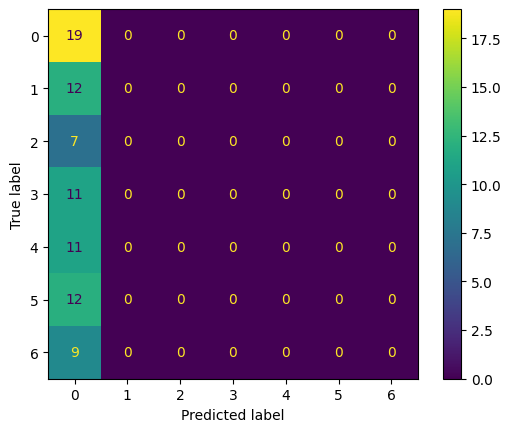


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['anger(0)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['anger(0)']

Label: sadness(6)
Hard cases of false negatives: ['anger(0)']



In [8]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

In [9]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()


Evaluation: f1_score
94.13% for the train data
72.80% for the test data

Evaluation: accuracy_score
94.05% for the train data
74.07% for the test data

Evaluation: precision_score
95.06% for the train data
77.43% for the test data

Evaluation: recall_score
93.51% for the train data
71.12% for the test data

Evaluation: confusion_matrix of test predictions


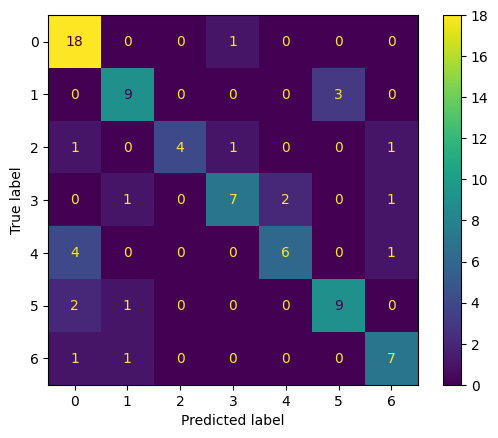


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [10]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

This is actually a really good result! We achieve 94.13% F1 macro on train set and 72.80% on the test set.

### Try with 90-10 train-test split as in paper

In [11]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3, test_size=0.1)

A snippet of the training data:


energy_max  energy_mean  energy_var  energy_rising_duration_max  \
237    0.109759     0.171386    0.237628                    0.627134   
459   -0.957895     0.300091   -0.525615                   -0.790542   
142   -0.957895     1.185660    0.922756                   -0.317983   
148    0.109759     0.104880   -1.020438                    1.099692   
124   -0.957895    -1.492359   -1.505395                   -0.790542   

     energy_rising_duration_mean  energy_rising_duration_median  \
237                    -0.605913                      -1.619339   
459                    -0.605913                      -0.403414   
142                    -0.315307                       0.812510   
148                     0.844674                      -0.403414   
124                    -0.034469                       0.812510   

     energy_rising_duration_iqr  energy_falling_duration_max  \
237                    0.245196                     0.852048   
459                   -0.569585                    -0.218012   
142                   -0.297992                    -0.574699   
148                   -0.297992                     1.922108   
124                   -1.384366                     0.138674   

     energy_falling_duration_mean  energy_falling_duration_median  ...  \
237                      0.507574                       -0.022437  ...   
459                     -1.149648                       -1.917803  ...   
142                     -0.427269                       -0.022437  ...   
148                      2.183007                        0.609351  ...   
124                     -0.639733                       -0.654226  ...   

     lpcmfccs_local9_max  lpcmfccs_local9_min  lpcmfccs_local10_mean  \
237            -0.195091             0.181742               0.336446   
459            -0.582417             0.199928               0.503072   
142             0.576409             0.176065              -0.780526   
148             2.640015             0.174058              -2.495015   
124            -0.036084            -0.445666               0.079640   

     lpcmfccs_local10_var  lpcmfccs_local10_max  lpcmfccs_local10_min  \
237             -0.217264             -0.207184              0.209326   
459             -0.230901             -0.208053              0.550008   
142              0.008446             -0.190744             -0.532065   
148              1.687736             -0.185442             -2.621600   
124             -0.194174              0.541278              0.060275   

     lpcmfccs_local11_mean  lpcmfccs_local11_var  lpcmfccs_local11_max  \
237               0.351303             -0.227112             -0.166875   
459               0.544656             -0.246933             -0.195199   
142              -0.872273              0.049954             -0.160583   
148              -2.503976              1.818091             -0.169745   
124               0.040702             -0.196731              0.345734   

     lpcmfccs_local11_min  
237              0.191852  
459              0.589683  
142             -0.586427  
148             -2.643904  
124              0.030599  

[5 rows x 186 columns]

There are 481 entries with 186 columns in the training data.
There are 54 entries with 186 columns in the testing data.


In [12]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()


Evaluation: f1_score
93.33% for the train data
72.99% for the test data

Evaluation: accuracy_score
93.35% for the train data
74.07% for the test data

Evaluation: precision_score
94.40% for the train data
76.13% for the test data

Evaluation: recall_score
92.60% for the train data
72.23% for the test data

Evaluation: confusion_matrix of test predictions


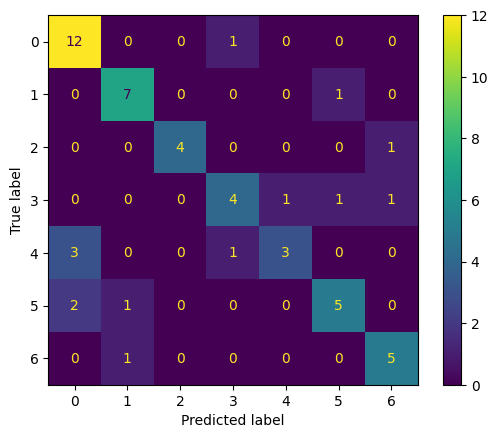


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['anger(0)']



In [13]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

The model is actually a bit better with a 85-15 train-test split. Just the hard cases change slightly.

### Try with 5 emotions only as in paper

In [4]:
# load the data
df_5emos = pd.read_pickle('../results/df_prep_5emos_numerical_only.pkl')

# selection of features
df_5emos = df_5emos.filter(regex='energy_|pitch_|lpccs_|^mfccs|lpcmfccs_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_5emos)

A snippet of the training data:


energy_max  energy_mean  energy_var  energy_rising_duration_max  \
121   -0.959314    -0.341210    0.157216                    0.089574   
211    0.173813     1.457029   -0.255004                    0.089574   
214    0.173813     0.244975    0.202045                   -0.384886   
317    0.173813    -1.746296   -1.320630                    1.038493   
185    0.173813     0.127876   -0.651523                   -0.859346   

     energy_rising_duration_mean  energy_rising_duration_median  \
121                    -0.213874                      -0.346349   
211                    -0.518771                      -0.346349   
214                    -0.636040                      -0.346349   
317                     1.122986                       0.851736   
185                    -0.453101                       0.851736   

     energy_rising_duration_iqr  energy_falling_duration_max  \
121                   -0.382494                     0.388276   
211                   -0.382494                     4.081847   
214                   -0.923894                     0.388276   
317                   -0.382494                     0.388276   
185                   -0.382494                    -0.283283   

     energy_falling_duration_mean  energy_falling_duration_median  ...  \
121                     -0.278035                       -0.710346  ...   
211                      0.995960                       -0.710346  ...   
214                     -0.101635                        0.527738  ...   
317                      0.858760                        0.527738  ...   
185                     -0.513234                        0.527738  ...   

     lpcmfccs_local9_max  lpcmfccs_local9_min  lpcmfccs_local10_mean  \
121             1.327561             0.193975              -1.469343   
211            -0.626460             0.195514               0.494667   
214             0.008417             0.192571              -0.220122   
317            -0.269358            -0.213231               0.159834   
185            -0.626033             0.189301               0.513010   

     lpcmfccs_local10_var  lpcmfccs_local10_max  lpcmfccs_local10_min  \
121              0.404402             -0.199982             -1.292353   
211             -0.249350             -0.200395              0.600694   
214             -0.138455             -0.200538              0.019050   
317             -0.219431              0.290115              0.282554   
185             -0.249367             -0.199900              0.600355   

     lpcmfccs_local11_mean  lpcmfccs_local11_var  lpcmfccs_local11_max  \
121              -1.568698              0.480893             -0.201294   
211               0.522463             -0.265745             -0.175649   
214              -0.261147             -0.120346             -0.186933   
317               0.140911             -0.223016              0.128936   
185               0.551992             -0.265790             -0.190624   

     lpcmfccs_local11_min  
121             -1.335401  
211              0.632186  
214             -0.014594  
317              0.266377  
185              0.631739  

[5 rows x 186 columns]

There are 288 entries with 186 columns in the training data.
There are 51 entries with 186 columns in the testing data.


In [5]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()


Evaluation: f1_score
96.29% for the train data
84.92% for the test data

Evaluation: accuracy_score
95.83% for the train data
84.31% for the test data

Evaluation: precision_score
96.36% for the train data
84.92% for the test data

Evaluation: recall_score
96.25% for the train data
84.92% for the test data

Evaluation: confusion_matrix of test predictions


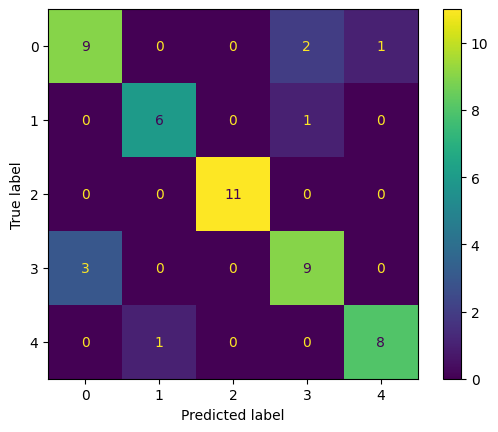


Hard cases for the model:

Label: boredom(0)
Hard cases of false positives: ['neutral(3)']

Label: neutral(3)
Hard cases of false negatives: ['boredom(0)']



In [6]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True, emotions='5emos')

Do the same with the 90-10 train-test split.

In [7]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_5emos, test_size=0.1)

A snippet of the training data:


energy_max  energy_mean  energy_var  energy_rising_duration_max  \
102    2.440066     0.809484    0.662290                    1.038493   
53    -0.959314     0.613678   -0.366092                    0.564033   
303    2.440066     1.530193    0.500537                   -0.859346   
24    -0.959314    -1.651078   -1.749471                    0.564033   
225    0.173813    -1.068863   -0.337114                   -1.333805   

     energy_rising_duration_mean  energy_rising_duration_median  \
102                     1.221491                      -0.346349   
53                     -0.673290                      -1.544435   
303                     0.384195                       0.252694   
24                     -1.466754                      -1.544435   
225                    -0.748617                      -0.346349   

     energy_rising_duration_iqr  energy_falling_duration_max  \
102                   -1.465294                     0.052496   
53                     0.700307                     0.388276   
303                    0.158907                     1.059834   
24                    -0.382494                     0.724055   
225                   -1.465294                    -1.290620   

     energy_falling_duration_mean  energy_falling_duration_median  ...  \
102                      1.627077                        0.527738  ...   
53                      -1.045890                       -1.948430  ...   
303                      1.956355                        1.765822  ...   
24                      -1.655087                       -1.948430  ...   
225                     -0.842512                        0.527738  ...   

     lpcmfccs_local9_max  lpcmfccs_local9_min  lpcmfccs_local10_mean  \
102             0.220540             0.197275              -0.350249   
53             -0.630595             0.122621               0.529800   
303             0.155025             0.194212              -0.232478   
24             -0.384799             0.078785               0.381732   
225            -0.248547            -3.239745               0.324050   

     lpcmfccs_local10_var  lpcmfccs_local10_max  lpcmfccs_local10_min  \
102             -0.094845             -0.200153             -0.186488   
53              -0.249467             -0.103445              0.603975   
303             -0.139021             -0.200809             -0.122690   
24              -0.244781             -0.049103              0.389247   
225             -0.237815              3.395994              0.263107   

     lpcmfccs_local11_mean  lpcmfccs_local11_var  lpcmfccs_local11_max  \
102              -0.408133             -0.071523             -0.202954   
53                0.578454             -0.266005             -0.156017   
303              -0.289573             -0.123887             -0.183898   
24                0.386225             -0.258489             -0.117118   
225               0.318203             -0.249077              3.060619   

     lpcmfccs_local11_min  
102             -0.228190  
53               0.636512  
303             -0.162291  
24               0.383776  
225              0.245260  

[5 rows x 186 columns]

There are 305 entries with 186 columns in the training data.
There are 34 entries with 186 columns in the testing data.


In [8]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()


Evaluation: f1_score
96.69% for the train data
89.33% for the test data

Evaluation: accuracy_score
96.39% for the train data
88.24% for the test data

Evaluation: precision_score
96.93% for the train data
91.14% for the test data

Evaluation: recall_score
96.51% for the train data
88.50% for the test data

Evaluation: confusion_matrix of test predictions


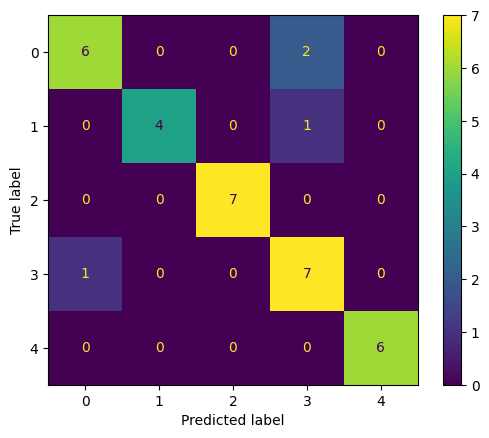


Hard cases for the model:

Label: boredom(0)
Hard cases of false negatives: ['neutral(3)']



In [10]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True, emotions='5emos')

Finally, we see that the model is even better with 5 emotions only. In this case, a 90-10 train-test split event improves the performance slighty. Only with *boredom* and *neutral* it has a hard time. Neverthesless, we are interested in comparing models' perfomances across all 7 emotions in EmoDB which is why we will move on with this dataset (and a 85-15 train-test split) from now on.

### Test the model performance with a selection of features as in paper 3
### 1) Only energy and pitch

A snippet of the training data:


energy_max  energy_mean  energy_var  energy_rising_duration_max  \
241    0.109759     1.184469    1.719364                   -0.317983   
364   -0.957895    -1.575339   -1.830023                   -0.317983   
209   -0.957895    -1.598139   -1.561260                   -0.790542   
430   -0.957895    -0.070193   -0.489470                   -1.263100   
309    2.245066     0.775073    0.472092                    1.099692   

     energy_rising_duration_mean  energy_rising_duration_median  \
241                    -1.221313                      -1.011377   
364                    -1.094613                      -0.403414   
209                    -0.346797                       0.812510   
430                    -0.811046                       0.812510   
309                    -0.354158                      -0.403414   

     energy_rising_duration_iqr  energy_falling_duration_max  \
241                   -0.026398                    -0.931386   
364                   -0.297992                    -1.288073   
209                   -0.841179                    -1.288073   
430                   -0.297992                    -1.288073   
309                    1.331571                    -1.288073   

     energy_falling_duration_mean  energy_falling_duration_median  ...  \
241                     -0.958430                       -0.022437  ...   
364                     -0.602240                        0.609351  ...   
209                     -0.941656                        0.609351  ...   
430                     -0.852198                        0.609351  ...   
309                     -1.393016                       -1.917803  ...   

     pitch_falling_duration_median  pitch_falling_duration_iqr  \
241                      -0.834149                    0.180696   
364                      -0.072163                   -0.040017   
209                      -0.326159                    0.622122   
430                       0.689823                   -0.260730   
309                       1.705805                   -0.260730   

     pitch_rising_value_max  pitch_rising_value_mean  \
241               -1.329934                -1.360738   
364                1.092121                -1.212129   
209               -1.010090                -0.470421   
430               -0.933011                 0.570475   
309                0.244524                 0.961703   

     pitch_rising_value_median  pitch_rising_value_iqr  \
241                  -0.868603               -0.968879   
364                  -0.779508               -0.960817   
209                   0.382565               -0.181758   
430                   1.485465                0.054747   
309                   0.725649               -0.034439   

     pitch_falling_value_max  pitch_falling_value_mean  \
241                 0.318704                  1.288659   
364                 0.301543                  1.138816   
209                 0.082893                  0.175622   
430                 0.317400                 -0.453870   
309                -0.551866                 -0.935010   

     pitch_falling_value_median  pitch_falling_value_iqr  
241                    0.869517                -0.927559  
364                    0.619213                -0.778304  
209                   -0.004860                -0.159984  
430                   -0.454121                 0.375208  
309                   -1.252798                 0.113163  

[5 rows x 38 columns]

There are 454 entries with 38 columns in the training data.
There are 81 entries with 38 columns in the testing data.

Evaluation: f1_score
81.50% for the train data
45.90% for the test data

Evaluation: accuracy_score
82.38% for the train data
51.85% for the test data

Evaluation: precision_score
84.12% for the train data
48.00% for the test data

Evaluation: recall_score
80.13% for the train data
47.04% for the test data

Evaluation: confusion_matrix of test predictions


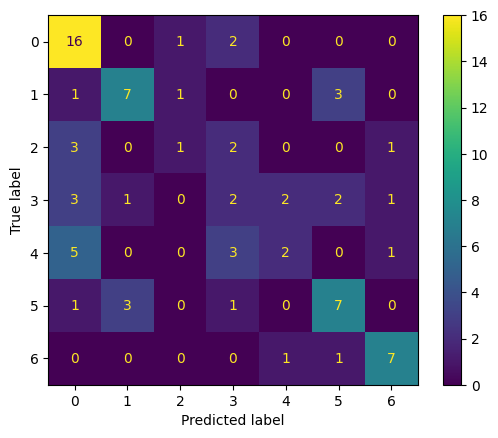


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)', 'fear(3)']
Hard cases of false positives: ['anger(0)', 'boredom(1)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)', 'fear(3)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [26]:
# select the features
df_3_ep = df_3.filter(regex='energy_|pitch_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_ep)

# train the model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

We get 81.50% F1 macro compared to 66.02% recognition rate with 5 emotions and 90-10 train-test split in paper 3.
### 2) Only LPCMFCC


Evaluation: f1_score
40.51% for the train data
35.97% for the test data

Evaluation: accuracy_score
49.56% for the train data
49.38% for the test data

Evaluation: precision_score
54.60% for the train data
36.40% for the test data

Evaluation: recall_score
43.45% for the train data
41.96% for the test data

Evaluation: confusion_matrix of test predictions


C:\Users\Kim-Carolin\anaconda3\envs\automatic_speech_emotion_recognition\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


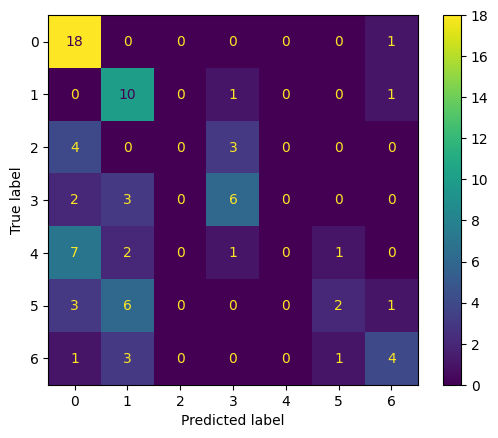


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)', 'fear(3)']

Label: fear(3)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['disgust(2)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['anger(0)', 'boredom(1)']
Hard cases of false positives: ['happiness(4)', 'sadness(6)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)']



In [28]:
# select the features
df_3_lpcmfcc = df_3.filter(regex='lpcmfccs_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_lpcmfcc, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

The LPCMFCC features alone don't seem to be very good or at least not sufficient enough. The model has a hard time at predicting emotions other than *anger* and *boredom*. We get 40.51% F1 macro compared to 70.7% recognition rate with 5 emotions and 90-10 train-test split in paper 3.


Evaluation: f1_score
55.03% for the train data
46.75% for the test data

Evaluation: accuracy_score
55.95% for the train data
48.15% for the test data

Evaluation: precision_score
56.72% for the train data
49.15% for the test data

Evaluation: recall_score
56.14% for the train data
47.55% for the test data

Evaluation: confusion_matrix of test predictions


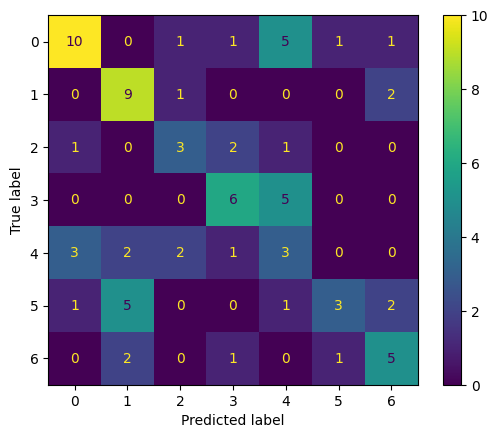


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']
Hard cases of false positives: ['happiness(4)']

Label: fear(3)
Hard cases of false negatives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)', 'fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)']



In [29]:
# change the model's hyperparameter
# train the model
svm_model = SVC(C=1, gamma=0.1, class_weight='balanced', decision_function_shape='ovo')
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

Especially balancing but also the other hyperparamaters can improve the model. Nevertheless, we are not as good as in paper 3. 
<br>  How about when we only use 5 emotions?


Evaluation: f1_score
62.34% for the train data
54.97% for the test data

Evaluation: accuracy_score
61.97% for the train data
52.94% for the test data

Evaluation: precision_score
63.42% for the train data
57.90% for the test data

Evaluation: recall_score
63.75% for the train data
56.71% for the test data

Evaluation: confusion_matrix of test predictions


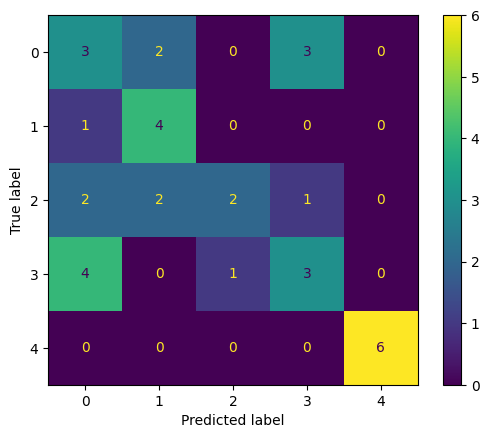


Hard cases for the model:

Label: boredom(0)
Hard cases of false negatives: ['disgust(1)', 'neutral(3)']
Hard cases of false positives: ['neutral(3)']

Label: disgust(1)
Hard cases of false positives: ['boredom(0)', 'happiness(2)']

Label: happiness(2)
Hard cases of false negatives: ['boredom(0)', 'disgust(1)']
Hard cases of false positives: ['neutral(3)']

Label: neutral(3)
Hard cases of false negatives: ['boredom(0)']
Hard cases of false positives: ['boredom(0)']



In [27]:
# load the train/test data
df_5emos_lpcmfccs = df_5emos.filter(regex='lpcmfccs_|label')
X_train, X_test, y_train, y_test = load_train_test_data(df_5emos_lpcmfccs, test_size=0.1, verbose=False)

# train the model
svm_model = SVC(C=1, gamma=0.1, class_weight='balanced', decision_function_shape='ovo')
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True, emotions='5emos')

We are getting closer to the results in paper 3 for LPCMFCC features only. We can see that the hyperparameters have a huge impact for the model to capture the features in the best manner.

### 3) energy, pitch, LPCC, MFCC


Evaluation: f1_score
95.27% for the train data
74.68% for the test data

Evaluation: accuracy_score
95.15% for the train data
76.54% for the test data

Evaluation: precision_score
96.03% for the train data
80.73% for the test data

Evaluation: recall_score
94.70% for the train data
73.06% for the test data

Evaluation: confusion_matrix of test predictions


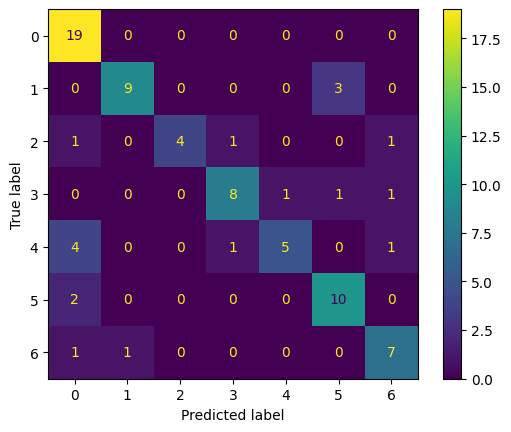


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [9]:
# select the features
df_3_eplm = df_3.filter(regex='energy_|pitch_|lpccs_|^mfccs|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_eplm, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

### 4) energy, pitch, LPCMFCC


Evaluation: f1_score
77.58% for the train data
42.16% for the test data

Evaluation: accuracy_score
78.63% for the train data
48.15% for the test data

Evaluation: precision_score
80.31% for the train data
44.54% for the test data

Evaluation: recall_score
76.41% for the train data
42.98% for the test data

Evaluation: confusion_matrix of test predictions


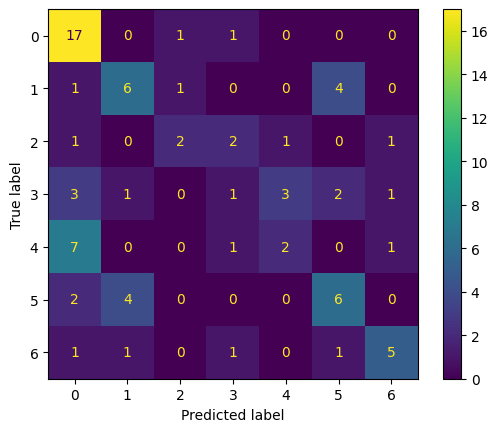


Hard cases for the model:

Label: anger(0)
Hard cases of false positives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']
Hard cases of false positives: ['anger(0)', 'boredom(1)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)', 'happiness(4)']
Hard cases of false positives: ['disgust(2)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [6]:
# select the features
df_3_eplpcmfcc = df_3.filter(regex='energy_|pitch_|lpcmfccs_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_eplpcmfcc, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

Finally, it seems like the model with Energy, pitch, lpccs, and mfccs is the strongest. It could be that the computation of lpcmfccs is not sufficient enough to hold both advantages of lpccs and mfccs in this case. We will try if further finetuning for the best model still increases its performance.

### Hyperparameter Optimization best model 

In [8]:
# train model on best features again

# select the features
df_3_eplm = df_3.filter(regex='energy_|pitch_|lpccs_|^mfccs|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_eplm, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# define the grid for the hyperparameter search
grid_vals = { 'C': [0.01, 0.1, 1, 10], 
            'gamma': [0.01, 0.1, 1, 10, 'scale', 'auto'],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'class_weight': ['balanced', None], 
            'decision_function_shape': ['ovo', 'ovr']
            }

run_gridsearchCV(svm_model, grid_vals, X_train, y_train, name_spec='paper3')

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_we

[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=scale, 

[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; tot

[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=poly; total t

[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None

[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[C

[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=linear; total time= 

[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1,

[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total ti

[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=li

[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_

[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight

[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_functio

[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=1, class_

[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END 

[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weigh

[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_fu

[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weigh

[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_func

[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=linear; to

[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=lin

[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=bala

[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=Non

[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, class

[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=Non

[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=sigmoid; total time=   0.0s

Best hyperparameters 


Evaluation: f1_score
89.79% for the train data
72.83% for the test data

Evaluation: accuracy_score
89.43% for the train data
75.31% for the test data

Evaluation: precision_score
89.83% for the train data
74.94% for the test data

Evaluation: recall_score
89.78% for the train data
72.20% for the test data

Evaluation: confusion_matrix of test predictions


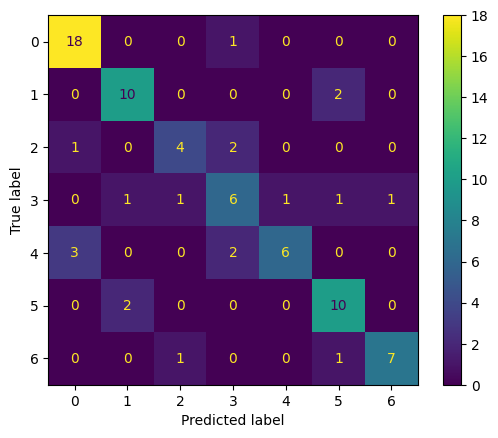


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [11]:
svm_best_model_paper3 = load_model('SVC', 'f1_macro', name_spec='paper3')
model_eval(svm_best_model_paper3, X_train, X_test, y_train, y_test, confusion=True)

In [16]:
params_best_svm = svm_best_model_paper3.get_params()
params_best_svm

{'C': 0.01,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 0.01,
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Even though we already achieve quite good results, we can still see that the model is overfitting to our data. Therefore, we will apply some dimensionality reduction/ feature selection.
## Dimensionality Reduction (Feature Selection)
For this, we also load the whole dataset with all statistics.

In [5]:
# load the data
df = pd.read_pickle('../results/df_prep_numerical_only.pkl')
print(df.columns)
df_all_stats = pd.read_pickle('../results/df_prep_numerical_only_all_stats.pkl')
print(df_all_stats.columns)

Index(['duration', 'mean', 'median', 'max', 'min', 'var', 'std',
       'speaking_rate', 'articulation_rate', 'asd',
       ...
       'lpc_local2_min', 'lpc_local3_mean', 'lpc_local3_var', 'lpc_local3_max',
       'lpc_local3_min', 'lpc_local4_mean', 'lpc_local4_var', 'lpc_local4_max',
       'lpc_local4_min', 'label'],
      dtype='object', length=270)
Index(['duration', 'mean', 'median', 'max', 'min', 'var', 'std',
       'speaking_rate', 'articulation_rate', 'asd',
       ...
       'value_rising_energy_iqr', 'value_falling_energy_iqr',
       'duration_rising_pitch_iqr', 'duration_falling_pitch_iqr',
       'value_rising_pitch_iqr', 'value_falling_pitch_iqr', 'skew_log_pitch',
       'range_log_pitch', 'range_log_energy', 'label'],
      dtype='object', length=596)


### 1) PCA

In [9]:
# create the dataset of principal components
pca = PCA(0.9)
principalComponents = pca.fit_transform(df_3.drop('label', axis=1))

principal_df = pd.DataFrame(data = principalComponents)
principal_df = pd.concat([principal_df, df_3[['label']]], axis = 1)

In [10]:
len(pca.explained_variance_ratio_)

34

In [11]:
pca.explained_variance_ratio_.sum()

0.9009038857850062


Evaluation: f1_score
89.47% for the train data
74.35% for the test data

Evaluation: accuracy_score
89.43% for the train data
76.54% for the test data

Evaluation: precision_score
90.92% for the train data
79.99% for the test data

Evaluation: recall_score
88.55% for the train data
73.39% for the test data

Evaluation: confusion_matrix of test predictions


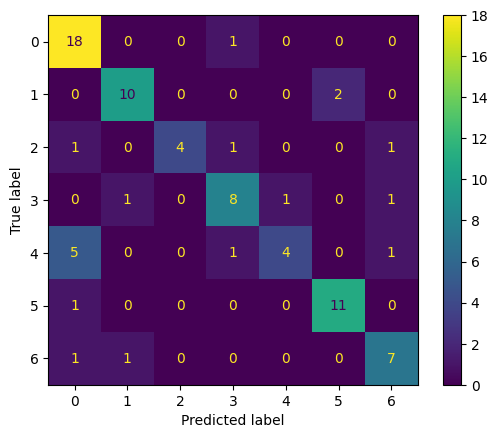


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [12]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

Keeping 90% variance, we can end up with a good result for train and test data while using only 34 features (principal components) instead of 186! (89.47% compared to 95.27% F1 macro for train, 74.35% compared to 74.68% F1 macro for test

In [33]:
# try with all created numerical features:

# create the dataset of principal components
pca = PCA(0.9)
principalComponents = pca.fit_transform(df.drop('label', axis=1))

principal_df = pd.DataFrame(data = principalComponents)
principal_df = pd.concat([principal_df, df[['label']]], axis = 1)

In [34]:
print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

47
[0.23196967 0.12281907 0.0675241  0.05374552 0.04676521 0.0309253
 0.03047724 0.02491181 0.02109577 0.02016766 0.01894271 0.01593638
 0.01406514 0.01367311 0.01212756 0.01102046 0.01076505 0.00986852
 0.00893571 0.0084468  0.00815084 0.00735054 0.00726901 0.00696108
 0.00654394 0.0058341  0.00558154 0.0052351  0.00496386 0.00481289
 0.00473103 0.00457154 0.00435873 0.0043216  0.00426994 0.00411253
 0.00408326 0.00396558 0.00385178 0.00380607 0.00372984 0.00350884
 0.00349901 0.00331704 0.00319952 0.00313462 0.00307176]



Evaluation: f1_score
94.16% for the train data
78.63% for the test data

Evaluation: accuracy_score
94.05% for the train data
80.25% for the test data

Evaluation: precision_score
95.00% for the train data
85.02% for the test data

Evaluation: recall_score
93.58% for the train data
76.74% for the test data

Evaluation: confusion_matrix of test predictions


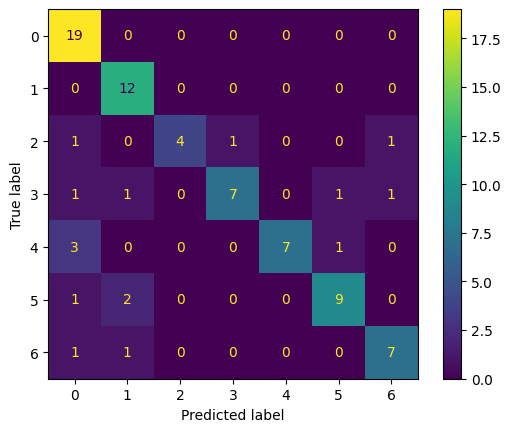


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [20]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
92.58% for the train data
81.60% for the test data

Evaluation: accuracy_score
92.52% for the train data
83.18% for the test data

Evaluation: precision_score
93.47% for the train data
85.23% for the test data

Evaluation: recall_score
91.94% for the train data
79.97% for the test data

Evaluation: confusion_matrix of test predictions


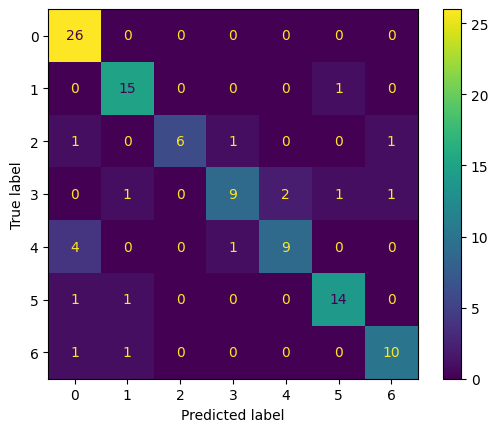


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [38]:
# with changed train/test ratio

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False, test_size=0.2)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

In [22]:
# and with all statistical features

# create the dataset of principal components
pca = PCA(0.9)
principalComponents = pca.fit_transform(df_all_stats.drop('label', axis=1))

principal_df = pd.DataFrame(data = principalComponents)
principal_df = pd.concat([principal_df, df[['label']]], axis = 1)

print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

103
[0.1371097  0.1225378  0.04878109 0.04306813 0.03503977 0.03143388
 0.02841167 0.02122009 0.01921022 0.01644826 0.01569456 0.01476704
 0.01442153 0.01311755 0.01305086 0.01188505 0.01135937 0.01061576
 0.01011364 0.00922488 0.00884234 0.00823372 0.00770304 0.00751619
 0.0071806  0.00701369 0.00693512 0.00659679 0.00637725 0.00610694
 0.00588616 0.00584404 0.00550799 0.00536687 0.00504853 0.00482218
 0.00472164 0.00452798 0.00438488 0.00430476 0.00414801 0.00408645
 0.0040593  0.00381127 0.00378764 0.00361238 0.00355297 0.00350895
 0.00345933 0.00336829 0.00329617 0.00314747 0.00311828 0.00304889
 0.0029914  0.00296533 0.00284535 0.0028187  0.00276443 0.0027123
 0.00267024 0.00261958 0.00260387 0.00251982 0.00244606 0.00243382
 0.0023608  0.00232406 0.00227299 0.00225475 0.00222684 0.00218453
 0.0021589  0.00212355 0.00208363 0.00205167 0.00204371 0.00196448
 0.00195309 0.00193649 0.00193473 0.00188694 0.00186865 0.00183865
 0.00183572 0.00179142 0.00176027 0.00173093 0.00172303 0.0


Evaluation: f1_score
97.85% for the train data
70.56% for the test data

Evaluation: accuracy_score
97.80% for the train data
72.84% for the test data

Evaluation: precision_score
98.32% for the train data
74.62% for the test data

Evaluation: recall_score
97.50% for the train data
69.38% for the test data

Evaluation: confusion_matrix of test predictions


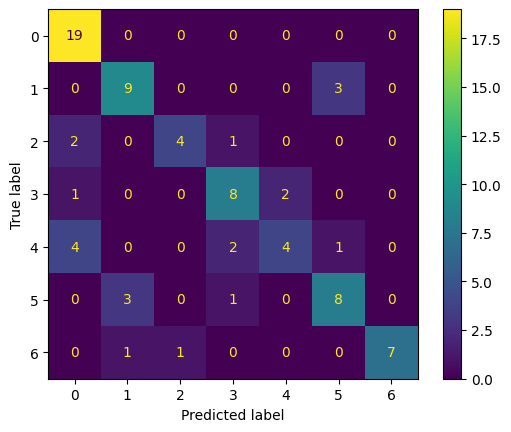


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [23]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False, test_size=0.2)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
97.93% for the train data
76.83% for the test data

Evaluation: accuracy_score
97.90% for the train data
78.50% for the test data

Evaluation: precision_score
98.34% for the train data
80.65% for the test data

Evaluation: recall_score
97.61% for the train data
75.55% for the test data

Evaluation: confusion_matrix of test predictions


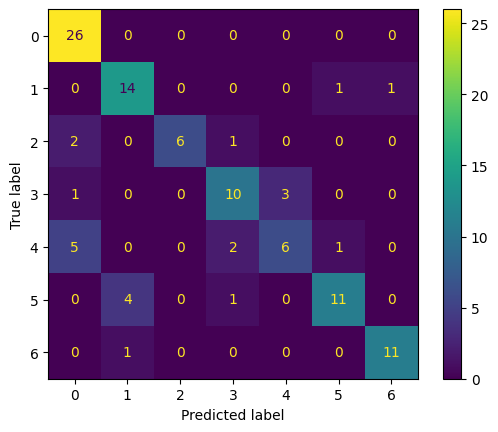


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: fear(3)
Hard cases of false negatives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [32]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False, test_size=0.2)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

### 2) Featurewiz

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (535, 187)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

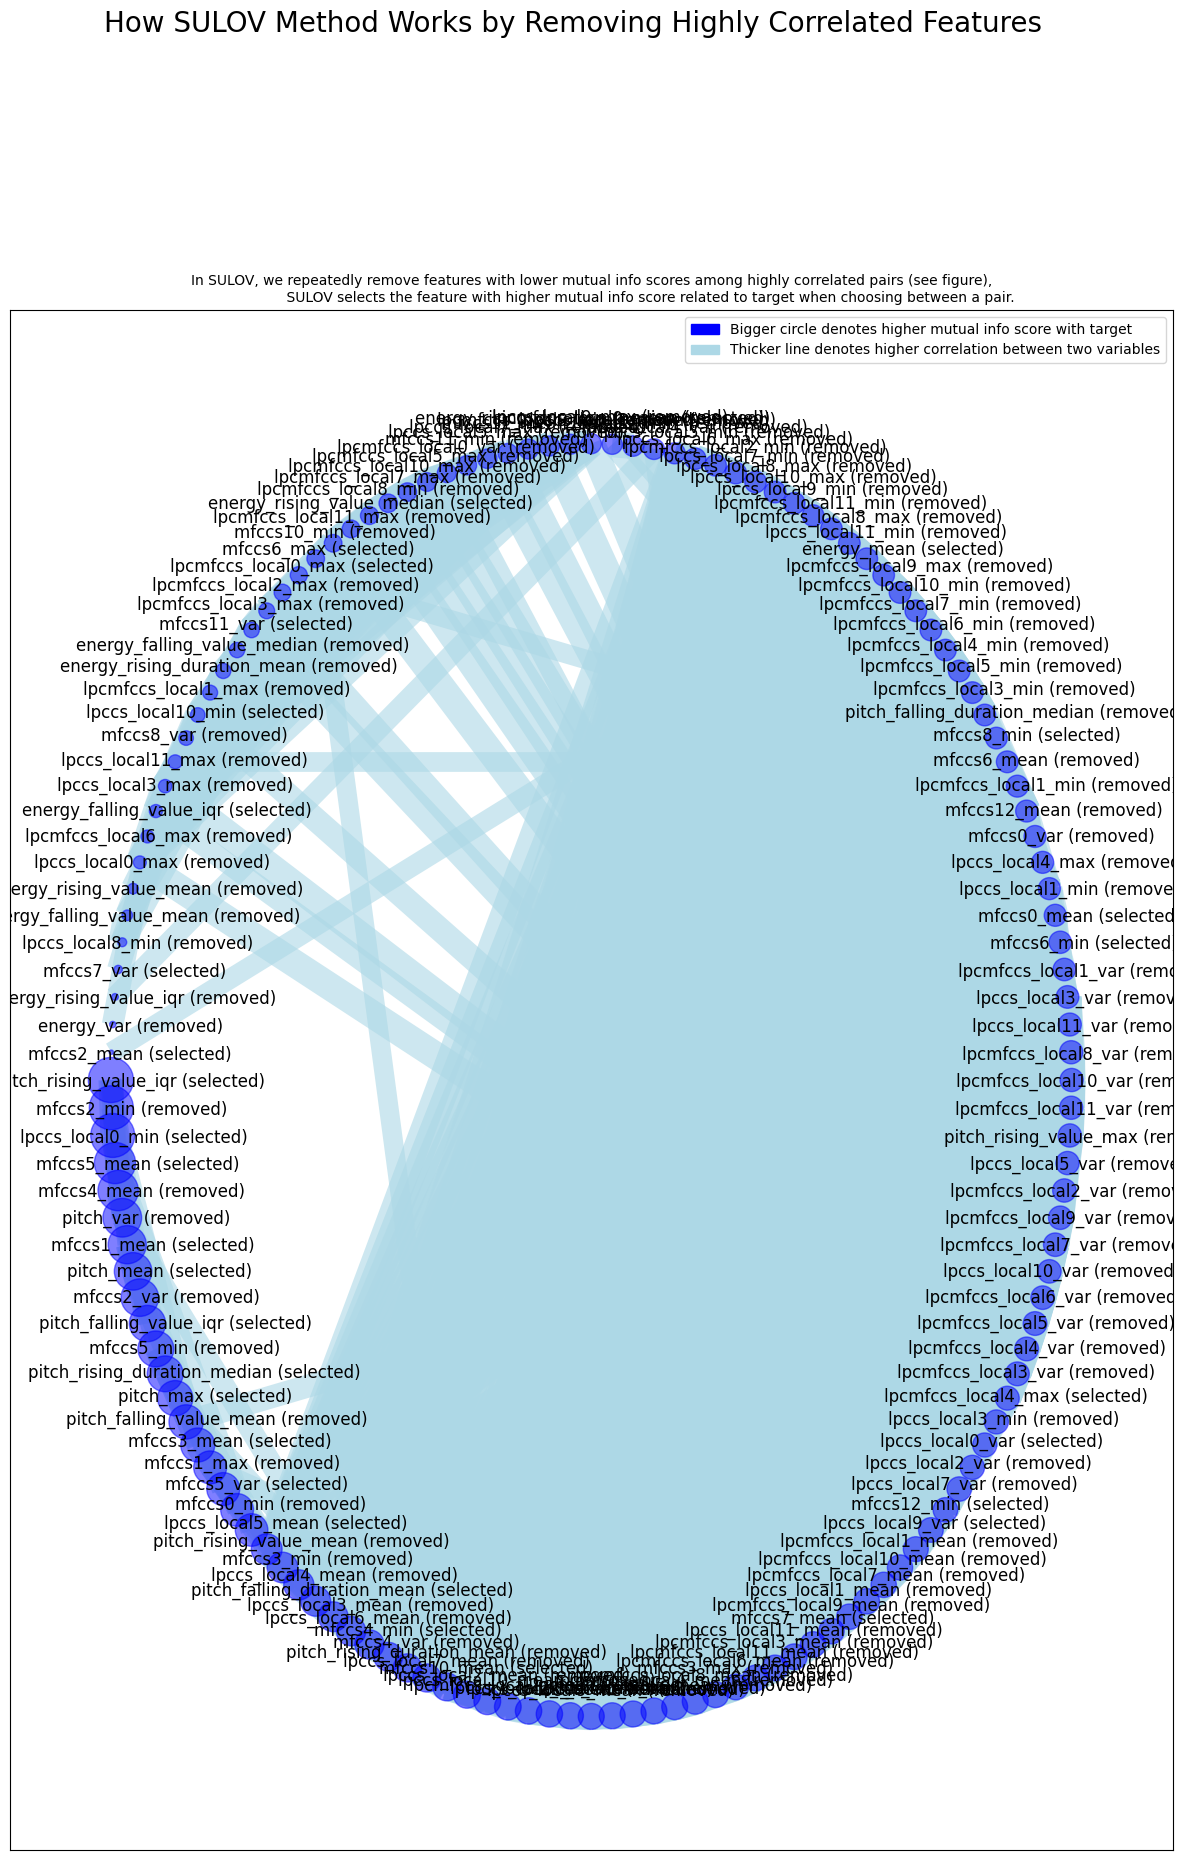

Time taken for SULOV method = 4 seconds
    Adding 0 categorical variables to reduced numeric variables  of 75
Finally 75 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 75 
    Taking top 27 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 75 variables...
            selecting 14 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds
        using 60 variables...
            selecting 12 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds


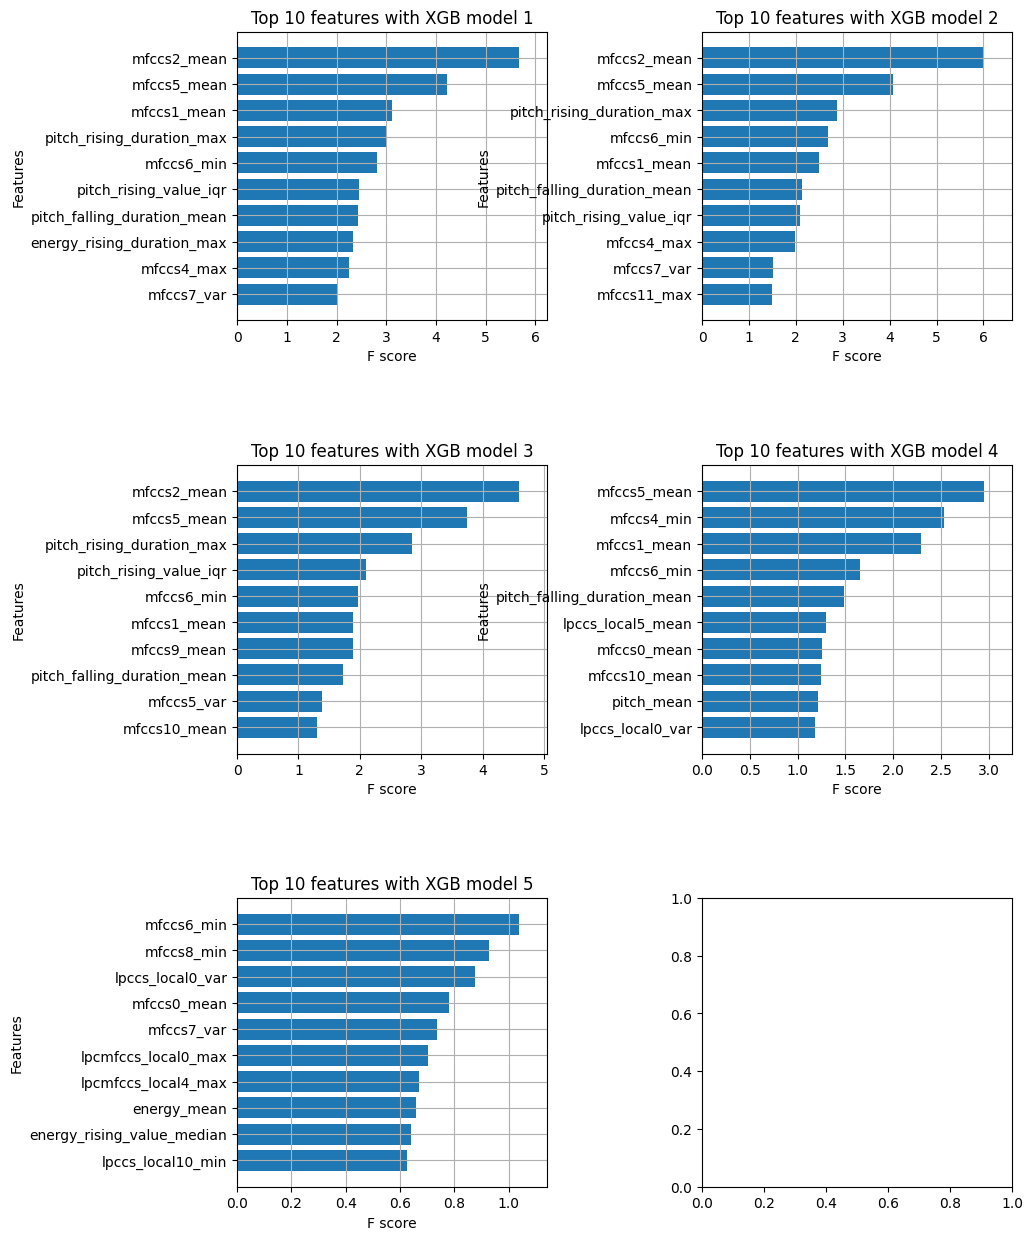

    Completed XGBoost feature selection in 2 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 20 important features:
['mfccs2_mean', 'mfccs5_mean', 'mfccs1_mean', 'pitch_rising_duration_max', 'mfccs6_min', 'pitch_rising_value_iqr', 'pitch_falling_duration_mean', 'energy_rising_duration_max', 'mfccs4_max', 'mfccs7_var', 'lpcmfccs_local0_max', 'mfccs0_mean', 'energy_falling_value_max', 'mfccs9_min', 'mfccs11_max', 'mfccs9_mean', 'mfccs5_var', 'mfccs10_mean', 'mfccs4_min', 'lpccs_local5_mean']
Total Time taken for featurewiz selection = 9 seconds
Output contains a list of 20 important features and a train dataframe


In [50]:
# automatic feature selection by using featurewiz package
target = 'label'
 
features, df_reduced = featurewiz(df_3, target, corr_limit=0.7, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [51]:
features

['mfccs2_mean',
 'mfccs5_mean',
 'mfccs1_mean',
 'pitch_rising_duration_max',
 'mfccs6_min',
 'pitch_rising_value_iqr',
 'pitch_falling_duration_mean',
 'energy_rising_duration_max',
 'mfccs4_max',
 'mfccs7_var',
 'lpcmfccs_local0_max',
 'mfccs0_mean',
 'energy_falling_value_max',
 'mfccs9_min',
 'mfccs11_max',
 'mfccs9_mean',
 'mfccs5_var',
 'mfccs10_mean',
 'mfccs4_min',
 'lpccs_local5_mean']


Evaluation: f1_score
87.03% for the train data
67.79% for the test data

Evaluation: accuracy_score
87.00% for the train data
69.14% for the test data

Evaluation: precision_score
88.11% for the train data
75.34% for the test data

Evaluation: recall_score
86.46% for the train data
67.87% for the test data

Evaluation: confusion_matrix of test predictions


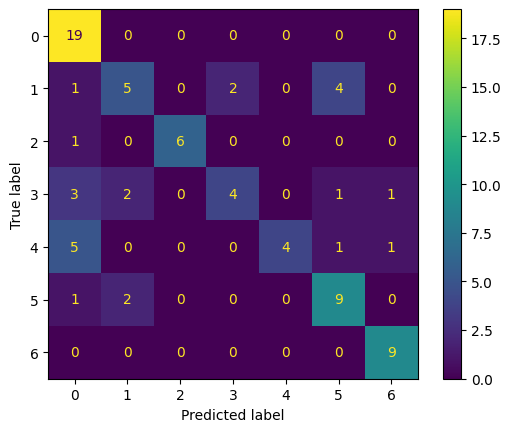


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['fear(3)', 'neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['boredom(1)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [54]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (535, 250)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

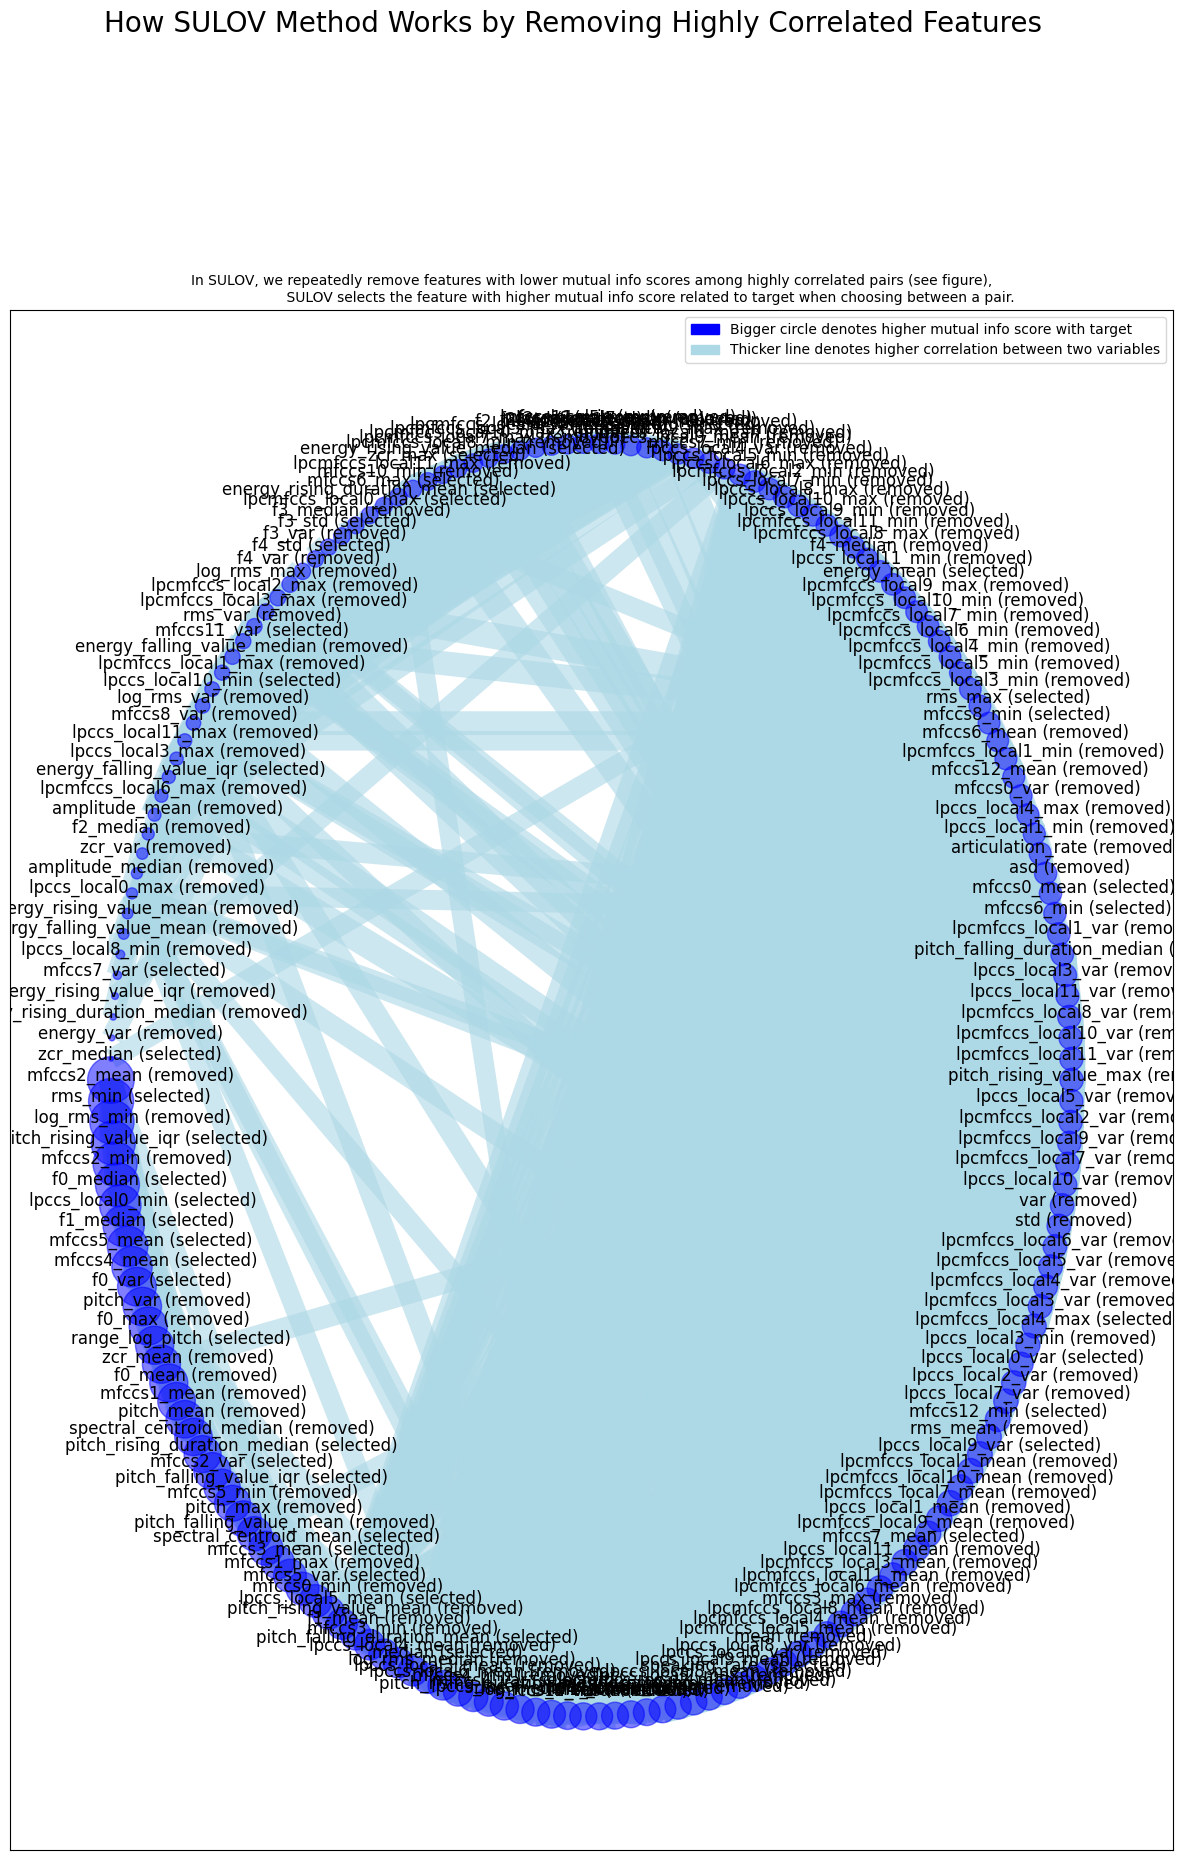

Time taken for SULOV method = 4 seconds
    Adding 0 categorical variables to reduced numeric variables  of 106
Finally 106 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 106 
    Taking top 37 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 106 variables...
            selecting 25 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds
        using 85 variables...
            selecting 20 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seco

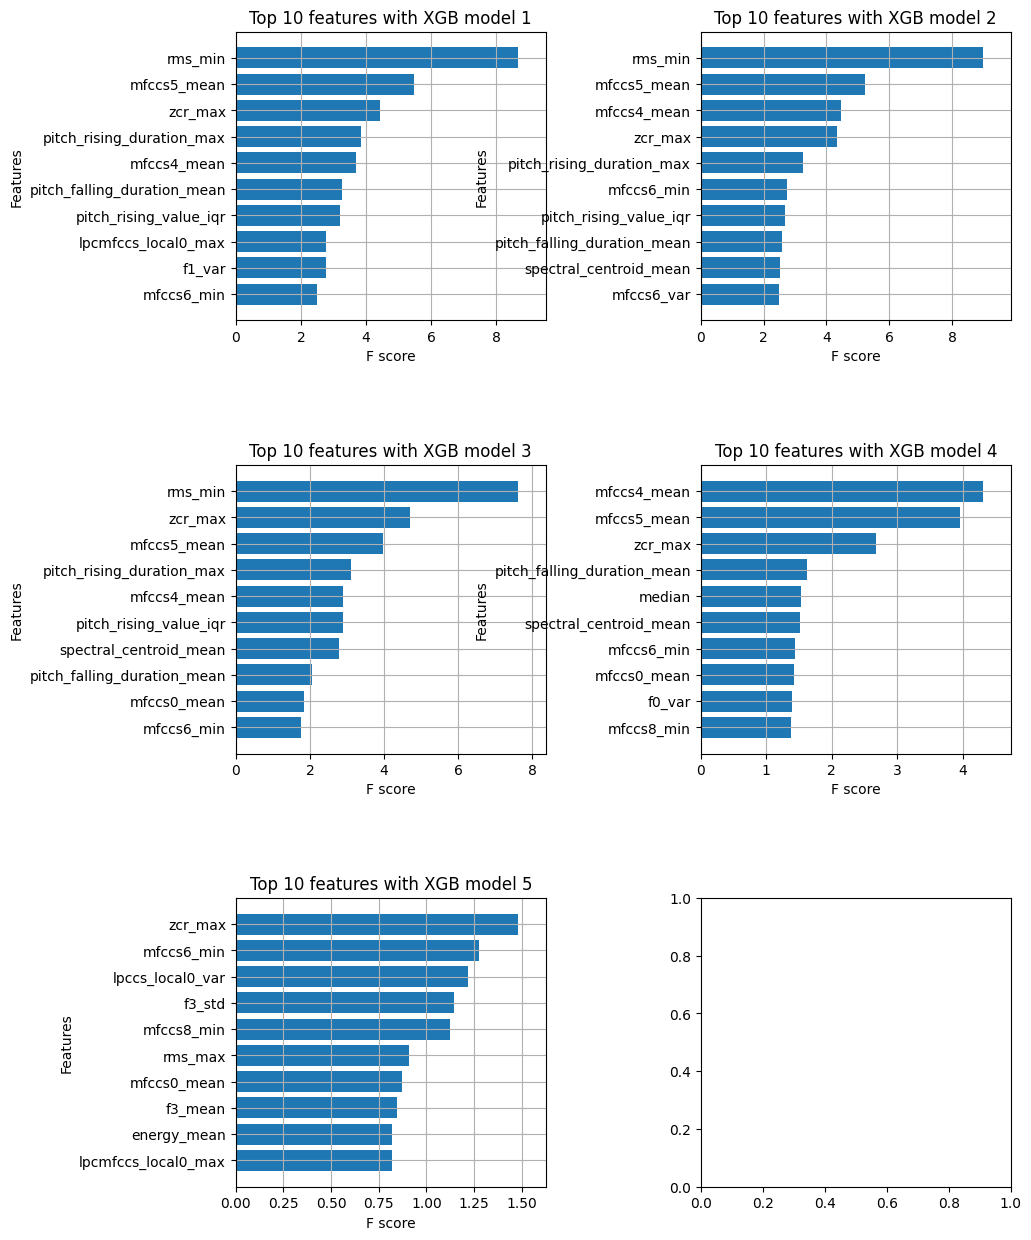

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 34 important features. Too many to print...
Total Time taken for featurewiz selection = 10 seconds
Output contains a list of 34 important features and a train dataframe


In [123]:
# try with created numerical features:

# automatic feature selection by using featurewiz package
target = 'label'
 
features_all, df_reduced_all = featurewiz(df, target, corr_limit=0.7, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [53]:
features_all

['rms_min',
 'mfccs5_mean',
 'zcr_max',
 'duration_rising_pitch_max',
 'lpccs_local4_min',
 'lfccs9_max',
 'min',
 'energy_median',
 'lfccs0_median',
 'lpccs_global_median',
 'lpc_global_mean',
 'value_falling_energy_max',
 'mfccs11_mean',
 'f1_min',
 'lpc_local3_var',
 'lpccs_local0_var',
 'f0_avg_change_rate_median',
 'lfccs9_median',
 'delta_mfccs0_min',
 'value_falling_pitch_iqr',
 'lpc_local1_mean',
 'f1_avg_change_rate_var',
 'threshold_entropy_var',
 'mfccs3_max',
 'f2_mean',
 'lfccs7_var',
 'lfccs9_var',
 'delta_mfccs5_median',
 'mfccs4_max',
 'energy_var',
 'delta2_mfccs3_min',
 'lpccs_local5_mean',
 'shannon_entropy_mean',
 'delta2_mfccs5_mean',
 'delta_mfccs4_median',
 'f3_mean',
 'mfccs5_var',
 'voiced_var',
 'duration_rising_energy_var',
 'lpc_local4_median',
 'f0_var',
 'lpcmfccs_global_min',
 'delta2_mfccs2_var',
 'duration_falling_pitch_iqr',
 'delta2_mfccs7_var',
 'lfccs6_mean',
 'delta2_mfccs6_median',
 'f3_avg_change_rate_median',
 'delta_mfccs6_median',
 'lfccs4_var


Evaluation: f1_score
91.54% for the train data
64.11% for the test data

Evaluation: accuracy_score
91.63% for the train data
66.67% for the test data

Evaluation: precision_score
92.04% for the train data
68.93% for the test data

Evaluation: recall_score
91.28% for the train data
63.50% for the test data

Evaluation: confusion_matrix of test predictions


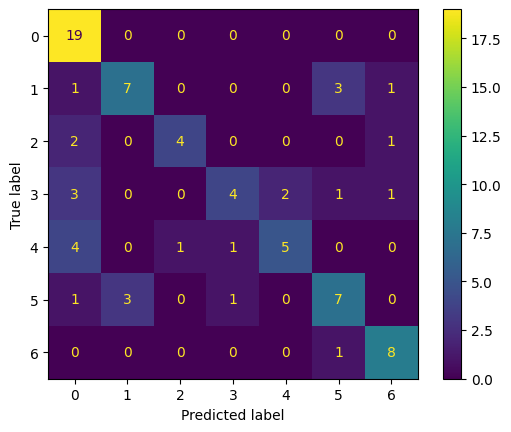


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [125]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced_all, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

With only 34 features we can achieve 91.54% F1 macro for the train data and 64.11% F1 macro for the test data!

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (535, 596)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

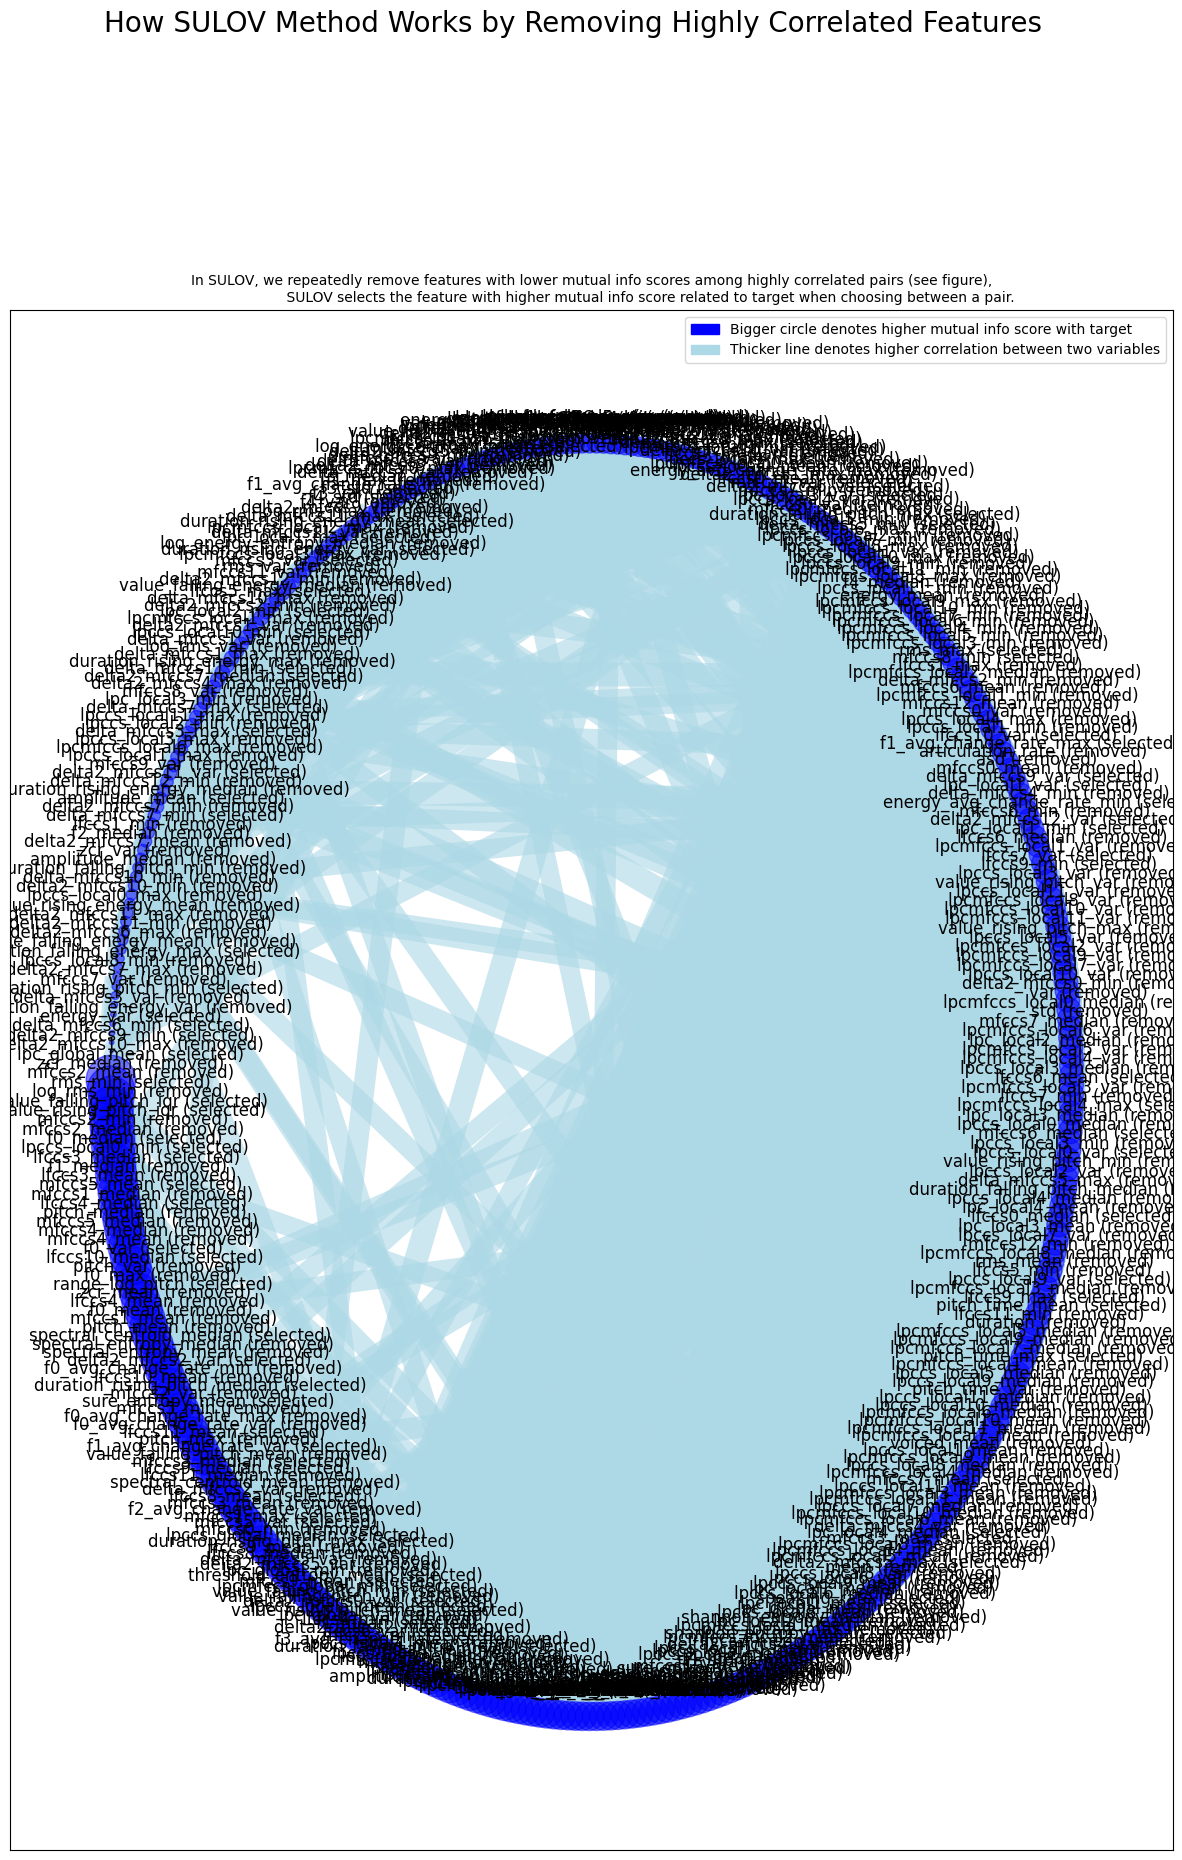

Time taken for SULOV method = 22 seconds
    Adding 0 categorical variables to reduced numeric variables  of 298
Finally 298 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 298 
    Taking top 89 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 298 variables...
            selecting 56 features in this iteration
            Time taken for regular XGBoost feature selection = 7 seconds
        using 238 variables...
            selecting 46 features in this iteration
            Time taken for regular XGBoost feature selection = 6 se

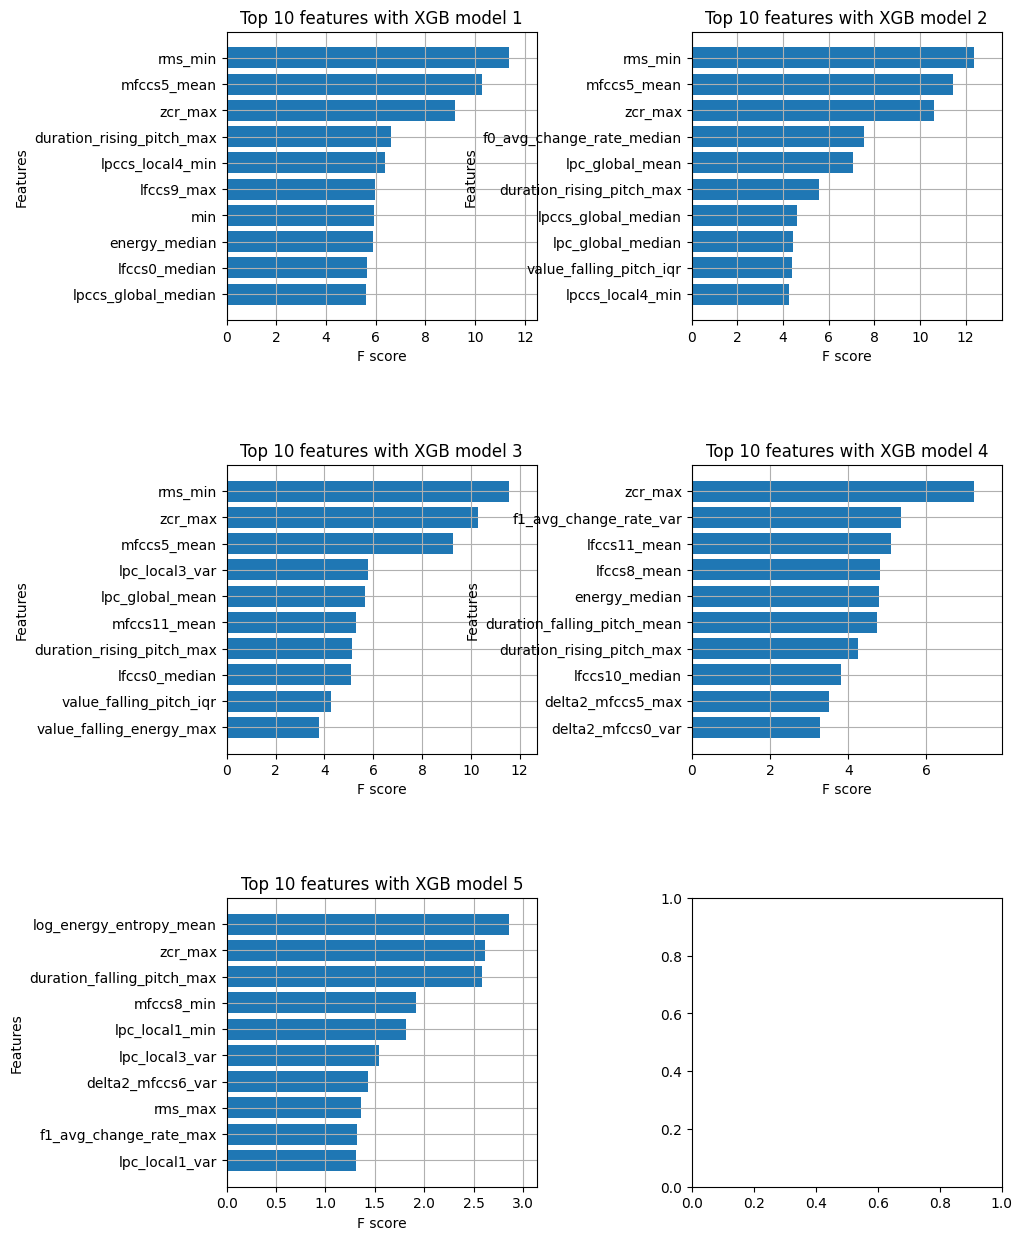

    Completed XGBoost feature selection in 6 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 97 important features. Too many to print...
Total Time taken for featurewiz selection = 50 seconds
Output contains a list of 97 important features and a train dataframe


In [6]:
# try with created numerical features (all stats):

# automatic feature selection by using featurewiz package
target = 'label'
 
features_all, df_reduced_all = featurewiz(df_all_stats, target, corr_limit=0.7, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [11]:
# save dataframe with most important features
df_reduced_all.to_pickle('../results/df_prep_most_important97.pkl')

In [7]:
features_all

['rms_min',
 'mfccs5_mean',
 'zcr_max',
 'duration_rising_pitch_max',
 'lpccs_local4_min',
 'lfccs9_max',
 'min',
 'energy_median',
 'lfccs0_median',
 'lpccs_global_median',
 'lpc_global_mean',
 'value_falling_energy_max',
 'mfccs11_mean',
 'f1_min',
 'lpc_local3_var',
 'lpccs_local0_var',
 'f0_avg_change_rate_median',
 'lfccs9_median',
 'delta_mfccs0_min',
 'value_falling_pitch_iqr',
 'lpc_local1_mean',
 'f1_avg_change_rate_var',
 'threshold_entropy_var',
 'mfccs3_max',
 'f2_mean',
 'lfccs7_var',
 'lfccs9_var',
 'delta_mfccs5_median',
 'mfccs4_max',
 'energy_var',
 'delta2_mfccs3_min',
 'lpccs_local5_mean',
 'shannon_entropy_mean',
 'delta2_mfccs5_mean',
 'delta_mfccs4_median',
 'f3_mean',
 'mfccs5_var',
 'voiced_var',
 'duration_rising_energy_var',
 'lpc_local4_median',
 'f0_var',
 'lpcmfccs_global_min',
 'delta2_mfccs2_var',
 'duration_falling_pitch_iqr',
 'delta2_mfccs7_var',
 'lfccs6_mean',
 'delta2_mfccs6_median',
 'f3_avg_change_rate_median',
 'delta_mfccs6_median',
 'lfccs4_var


Evaluation: f1_score
97.77% for the train data
72.94% for the test data

Evaluation: accuracy_score
97.58% for the train data
75.31% for the test data

Evaluation: precision_score
98.05% for the train data
79.96% for the test data

Evaluation: recall_score
97.57% for the train data
71.71% for the test data

Evaluation: confusion_matrix of test predictions


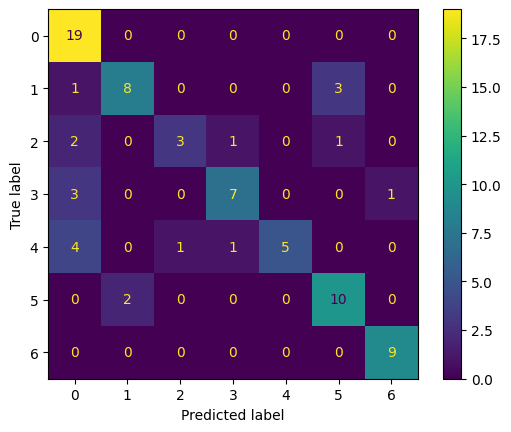


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['happiness(4)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [8]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced_all, verbose=False)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
98.27% for the train data
80.92% for the test data

Evaluation: accuracy_score
98.13% for the train data
81.37% for the test data

Evaluation: precision_score
98.62% for the train data
83.30% for the test data

Evaluation: recall_score
98.02% for the train data
79.65% for the test data

Evaluation: confusion_matrix of test predictions


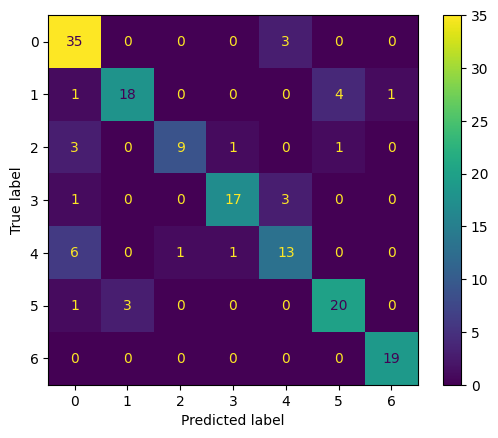


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [47]:
# with different split size

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced_all, verbose=False, test_size=0.3)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

In [18]:
# save model
pickle.dump('svm_model', open('../results/models/SVC_f1_macro_best_model_most_important97.pkl', 'wb'))

# Paper 2
### Liu et al. (2018) "Speech emotion recognition based on feature selection and extreme learning machine decision tree"

In [27]:
# read saved dataframe
df = pd.read_pickle('../results/df_prep_numerical_only_all_stats.pkl')

# feature selection
df_paper2 = df[['f0_max', 'f0_var', 'amplitude_max', 'energy_mean', 'amplitude_mean', 'zcr_mean', 'speaking_rate', 
                'spectral_centroid_mean', 'spectral_centroid_mean', 'f1_max', 'f1_mean', 'f1_std', 'f2_max', 'f2_mean', 
                'f2_std', 'f3_max', 'f3_std', 'f3_mean', 'f0_avg_change_rate_mean', 'energy_avg_change_rate_mean', 
                'amplitude_avg_change_rate_mean', 'f1_avg_change_rate_mean', 'f2_avg_change_rate_mean', 
                'f3_avg_change_rate_mean', 'label']]
df_paper2 = pd.concat([df_paper2, df.filter(regex='^(delta|mfccs|lfccs)\w+_mean$')], axis=1)
print(f'The dataframe has {len(df_paper2.columns)} columns.')
df_paper2.columns

The dataframe has 76 columns.


Index(['f0_max', 'f0_var', 'amplitude_max', 'energy_mean', 'amplitude_mean',
       'zcr_mean', 'speaking_rate', 'spectral_centroid_mean',
       'spectral_centroid_mean', 'f1_max', 'f1_mean', 'f1_std', 'f2_max',
       'f2_mean', 'f2_std', 'f3_max', 'f3_std', 'f3_mean',
       'f0_avg_change_rate_mean', 'energy_avg_change_rate_mean',
       'amplitude_avg_change_rate_mean', 'f1_avg_change_rate_mean',
       'f2_avg_change_rate_mean', 'f3_avg_change_rate_mean', 'label',
       'mfccs0_mean', 'mfccs1_mean', 'mfccs2_mean', 'mfccs3_mean',
       'mfccs4_mean', 'mfccs5_mean', 'mfccs6_mean', 'mfccs7_mean',
       'mfccs8_mean', 'mfccs9_mean', 'mfccs10_mean', 'mfccs11_mean',
       'mfccs12_mean', 'delta_mfccs0_mean', 'delta_mfccs1_mean',
       'delta_mfccs2_mean', 'delta_mfccs3_mean', 'delta_mfccs4_mean',
       'delta_mfccs5_mean', 'delta_mfccs6_mean', 'delta_mfccs7_mean',
       'delta_mfccs8_mean', 'delta_mfccs9_mean', 'delta_mfccs10_mean',
       'delta_mfccs11_mean', 'delta_mfccs12_me

In [28]:
# create train/test split
X_train, X_test, y_train, y_test = load_train_test_data(df_paper2, test_size=0.3)

A snippet of the data:


f0_max    f0_var  amplitude_max  energy_mean  amplitude_mean  zcr_mean  \
383  1.231016  0.681296       0.733353     0.317044        0.918490  1.340242   
180 -1.358694 -0.752244      -1.397406     1.236712       -0.574499 -1.911344   
447 -0.977852 -0.570377      -2.124781     0.816668        0.640429  0.972242   
409 -0.607699 -0.357108       0.733353     0.392123       -0.020029  0.664951   
268  0.723941  0.865626       0.733353     0.515033        0.189601  0.669922   

     speaking_rate  spectral_centroid_mean  spectral_centroid_mean    f1_max  \
383       0.446530                0.506801                0.506801  0.749154   
180       0.214744               -0.330219               -0.330219  0.422193   
447       1.541140                1.273873                1.273873  2.563538   
409      -0.034375                0.403946                0.403946 -0.834384   
268       0.738204                0.203537                0.203537  1.938499   

      f1_mean    f1_std    f2_max   f2_mean    f2_std    f3_max    f3_std  \
383 -0.095229 -0.520755 -0.520892  0.787750  0.538977  0.148376 -0.276466   
180  0.956602  2.375949  1.926849 -0.373516  2.600882  1.150584  1.938132   
447  1.474111  3.109221  0.682151  1.123658  2.237048  0.889632  2.728702   
409  0.321871 -0.759715 -0.835770 -0.989488 -1.409870 -0.874743 -1.124206   
268  1.243244 -0.616808  0.151561 -0.822185  0.500952  0.545710 -0.551651   

      f3_mean  f0_avg_change_rate_mean  energy_avg_change_rate_mean  \
383 -0.125812                  -0.3072                     0.062564   
180  1.509627                  -0.3072                     0.080092   
447  1.837903                  -0.3072                     2.478982   
409 -0.660298                  -0.3072                     0.061564   
268  0.253051                  -0.3072                     0.062067   

     amplitude_avg_change_rate_mean  f1_avg_change_rate_mean  \
383                        0.847746                -0.124972   
180                        0.818186                -0.635571   
447                       -0.654345                -0.537989   
409                       -1.115963                -0.542370   
268                        0.741523                -1.618366   

     f2_avg_change_rate_mean  f3_avg_change_rate_mean  mfccs0_mean  \
383                 0.021752                -0.510516     0.457343   
180                 0.047973                -0.347630     0.277321   
447                -1.116068                -0.406939     3.014764   
409                -1.240215                -0.742762    -0.234994   
268                -1.353465                -1.364033     0.450180   

     mfccs1_mean  mfccs2_mean  mfccs3_mean  mfccs4_mean  mfccs5_mean  \
383    -0.960655    -0.217877    -0.313628    -0.921892    -0.883268   
180     1.641698     1.122424    -0.045314     1.454875     2.981771   
447    -0.303937     1.202789    -0.264685     0.829963     2.016252   
409    -0.327325    -1.373864    -0.956468    -0.583640    -0.067690   
268    -0.634537    -1.093820    -1.853200    -1.693030    -1.481929   

     mfccs6_mean  mfccs7_mean  mfccs8_mean  mfccs9_mean  mfccs10_mean  \
383    -0.448372     0.476108    -1.403384    -1.655430     -0.626265   
180     2.726794    -0.098594     0.998729     0.829990      0.869278   
447     1.422007     1.494238     0.793258     0.850926     -0.040726   
409    -0.452259    -0.952026     0.207580     0.341977      0.846171   
268     1.162772    -1.546099    -0.413845     0.410130     -1.238801   

     mfccs11_mean  mfccs12_mean  delta_mfccs0_mean  delta_mfccs1_mean  \
383     -1.457795      0.098980           0.931772           0.535687   
180      0.474646      1.036108           0.205226          -0.064679   
447     -0.111309     -0.601218           0.842387          -0.536854   
409     -0.433176     -0.695221          -1.529378          -1.021420   
268      1.053325     -1.282359           0.140378           1.460620   

     delta_mfccs2_mean  delta_mf

There are 374 entries with 75 columns in the training data.
There are 161 entries with 75 columns in the testing data.


## ELM Decision Tree
Extreme Learning Machines are supposedly really good for generalization and fast training with one hidden layer only and many hidden units. From "High Performance Extreme Learning Machines: A Complete Toolbox for Big Data Applications" in IEEE Access. http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=7140733&newsearch=true&queryText=High%20Performance%20Extreme%20Learning%20Machines
<br> Using scikit-elm: https://scikit-elm.readthedocs.io/en/latest/generated/skelm.ELMClassifier.html#skelm.ELMClassifier


Evaluation: f1_score
94.71% for the train data
66.80% for the test data

Evaluation: accuracy_score
94.65% for the train data
67.08% for the test data

Evaluation: precision_score
95.25% for the train data
69.00% for the test data

Evaluation: recall_score
94.38% for the train data
65.82% for the test data

Evaluation: confusion_matrix of test predictions


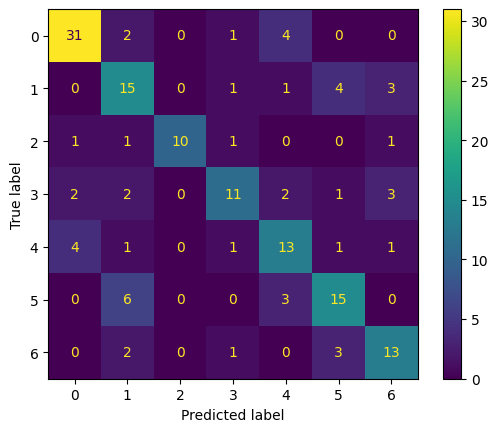


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [39]:
# with scikit-elm
elm = skelm.ELMClassifier(random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
95.37% for the train data
66.57% for the test data

Evaluation: accuracy_score
95.45% for the train data
66.46% for the test data

Evaluation: precision_score
95.76% for the train data
67.88% for the test data

Evaluation: recall_score
95.14% for the train data
65.70% for the test data

Evaluation: confusion_matrix of test predictions


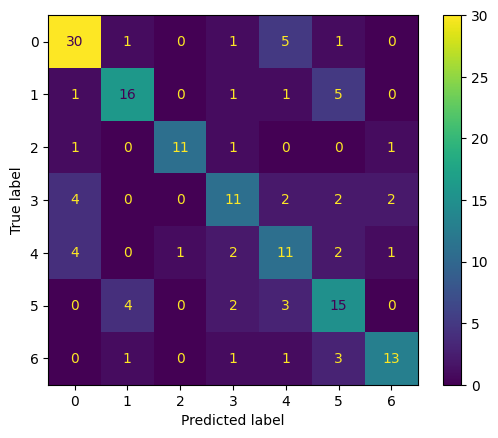


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']



In [47]:
elm = skelm.ELMClassifier(ufunc='sigm', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
97.41% for the train data
73.09% for the test data

Evaluation: accuracy_score
97.59% for the train data
73.91% for the test data

Evaluation: precision_score
97.77% for the train data
76.61% for the test data

Evaluation: recall_score
97.11% for the train data
71.74% for the test data

Evaluation: confusion_matrix of test predictions


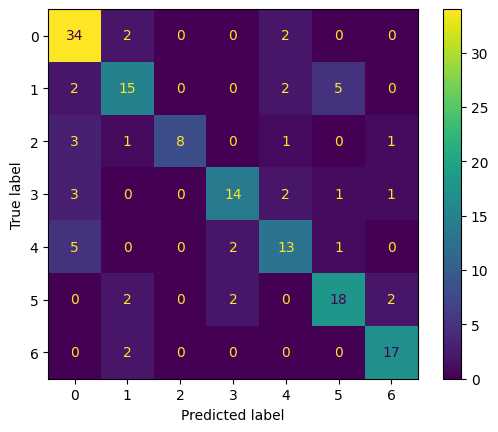


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [59]:
elm = skelm.ELMClassifier(pairwise_metric='euclidean', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
91.73% for the train data
80.27% for the test data

Evaluation: accuracy_score
91.98% for the train data
80.75% for the test data

Evaluation: precision_score
93.16% for the train data
82.24% for the test data

Evaluation: recall_score
90.85% for the train data
79.10% for the test data

Evaluation: confusion_matrix of test predictions


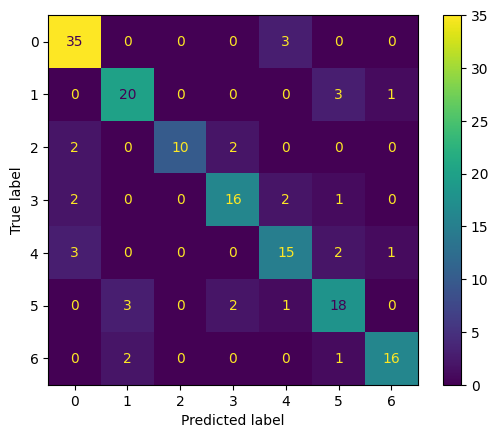


Hard cases for the model:



In [10]:
elm = skelm.ELMClassifier(pairwise_metric='cosine', random_state=0) # also achieved from n_neurons=74 (n_samples / 5 
                                                                    # which is often chosen as default) onwards
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)

Gridsearch is unfortunately not working with pairwise operator for skelm. Comparing different numbers of neurons in the hidden layers ("n_neurons"), shows very different results. Too few or too many neurons lead either to bad predicting or immense overfitting. Overall, leaving "n_neurons" per default brings better results here. "n_neurons=125" gives almost same results (125=n_samples/3).  


Evaluation: f1_score
94.75% for the train data
68.09% for the test data

Evaluation: accuracy_score
94.65% for the train data
70.19% for the test data

Evaluation: precision_score
95.86% for the train data
70.09% for the test data

Evaluation: recall_score
93.98% for the train data
67.36% for the test data

Evaluation: confusion_matrix of test predictions


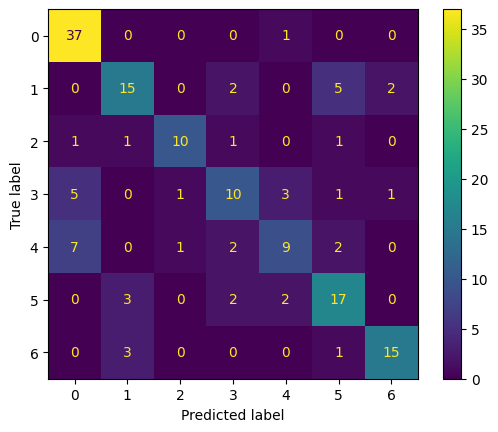


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [40]:
# compare with SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

### After Feature Selection

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.8 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
You have duplicate column names in your data set. Removing duplicate columns now...
    Loaded train data. Shape = (535, 76)
Removing 1 duplicate column(s) of Index(['spectral_centroid_mean'], dtype='object')
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################

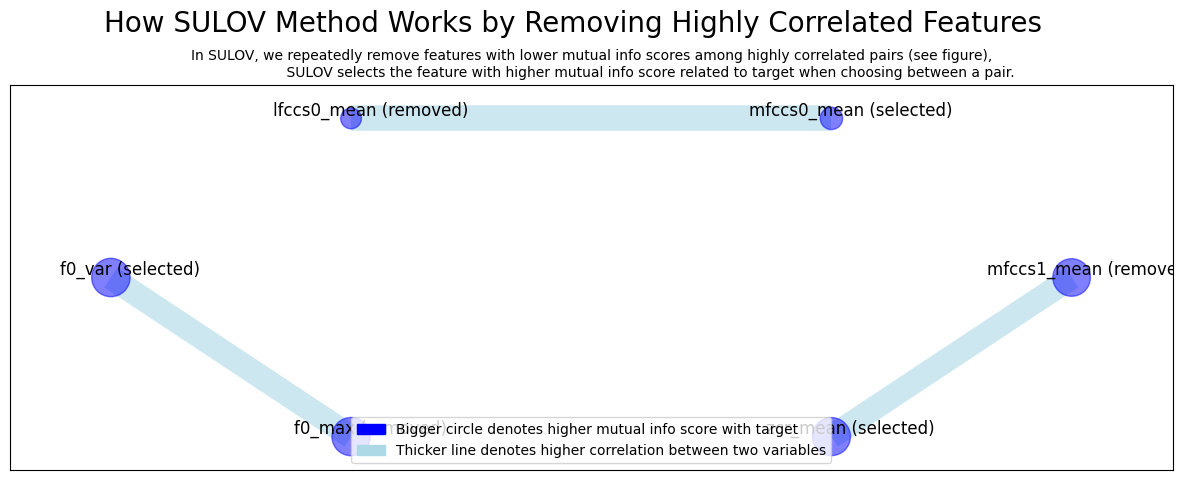

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 71
Finally 71 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 71 
    Taking top 11 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 71 variables...
            selecting 13 features in this iteration
            Time taken for regular XGBoost feature selection = 2 seconds
        using 57 variables...
            selecting 13 features in this iteration
            Time taken for regular XGBoost feature selection = 2 seconds


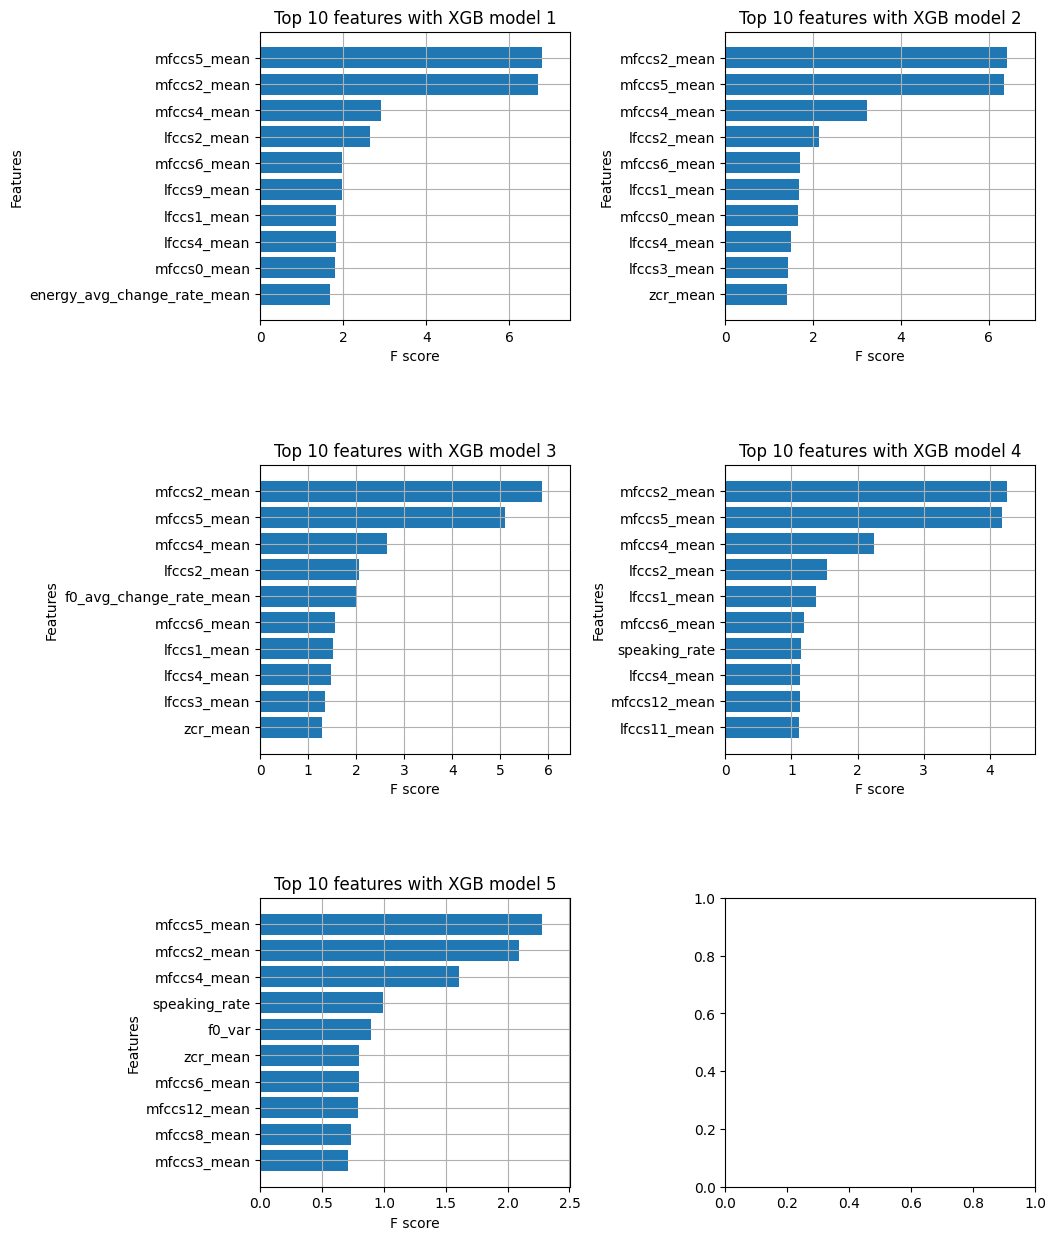

    Completed XGBoost feature selection in 3 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 16 important features:
['mfccs5_mean', 'mfccs2_mean', 'mfccs4_mean', 'lfccs2_mean', 'mfccs6_mean', 'lfccs9_mean', 'lfccs1_mean', 'lfccs4_mean', 'mfccs0_mean', 'energy_avg_change_rate_mean', 'lfccs11_mean', 'f0_var', 'zcr_mean', 'lfccs3_mean', 'mfccs12_mean', 'f0_avg_change_rate_mean']
Total Time taken for featurewiz selection = 13 seconds
Output contains a list of 16 important features and a train dataframe


In [17]:
# automatic feature selection by using featurewiz package
target = 'label'
 
selected_features_paper2, df_paper2_reduced = featurewiz(df_paper2, target, corr_limit=0.8, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [41]:
# reload train/test split with selected features
X_train, X_test, y_train, y_test = load_train_test_data(df_paper2_reduced, test_size=0.3)

A snippet of the data:


mfccs5_mean  mfccs2_mean  mfccs4_mean  lfccs2_mean  mfccs6_mean  \
383    -0.883268    -0.217877    -0.921892    -0.795953    -0.448372   
180     2.981771     1.122424     1.454875     1.460728     2.726794   
447     2.016252     1.202789     0.829963     0.028958     1.422007   
409    -0.067690    -1.373864    -0.583640    -0.523046    -0.452259   
268    -1.481929    -1.093820    -1.693030     0.144598     1.162772   

     lfccs9_mean  lfccs1_mean  lfccs4_mean  mfccs0_mean  \
383    -0.892070    -0.917224    -0.088791     0.457343   
180     0.190486     0.531760     1.462702     0.277321   
447     0.526651    -1.599763     0.191534     3.014764   
409    -1.464114     0.469496    -0.863401    -0.234994   
268    -1.221406    -0.456585    -1.296817     0.450180   

     energy_avg_change_rate_mean  lfccs11_mean    f0_var  zcr_mean  \
383                     0.062564     -0.264836  0.681296  1.340242   
180                     0.080092      2.534411 -0.752244 -1.911344   
447                     2.478982      0.474833 -0.570377  0.972242   
409                     0.061564     -0.409716 -0.357108  0.664951   
268                     0.062067     -1.648705  0.865626  0.669922   

     lfccs3_mean  mfccs12_mean  f0_avg_change_rate_mean  
383    -0.424256      0.098980                  -0.3072  
180     0.988820      1.036108                  -0.3072  
447     1.256182     -0.601218                  -0.3072  
409    -0.810094     -0.695221                  -0.3072  
268    -1.369024     -1.282359                  -0.3072

There are 374 entries with 16 columns in the training data.
There are 161 entries with 16 columns in the testing data.



Evaluation: f1_score
91.86% for the train data
52.49% for the test data

Evaluation: accuracy_score
91.98% for the train data
55.28% for the test data

Evaluation: precision_score
92.78% for the train data
54.13% for the test data

Evaluation: recall_score
91.33% for the train data
52.09% for the test data

Evaluation: confusion_matrix of test predictions


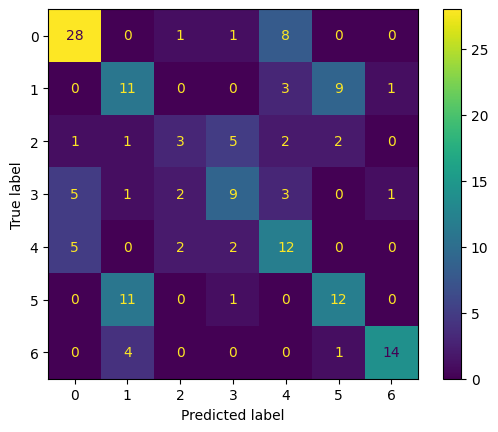


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']
Hard cases of false positives: ['fear(3)', 'happiness(4)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['disgust(2)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)']



In [45]:
# run best model settings with these features again
elm = skelm.ELMClassifier(pairwise_metric='euclidean', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
81.65% for the train data
54.86% for the test data

Evaluation: accuracy_score
82.89% for the train data
59.63% for the test data

Evaluation: precision_score
84.29% for the train data
65.16% for the test data

Evaluation: recall_score
80.57% for the train data
54.69% for the test data

Evaluation: confusion_matrix of test predictions


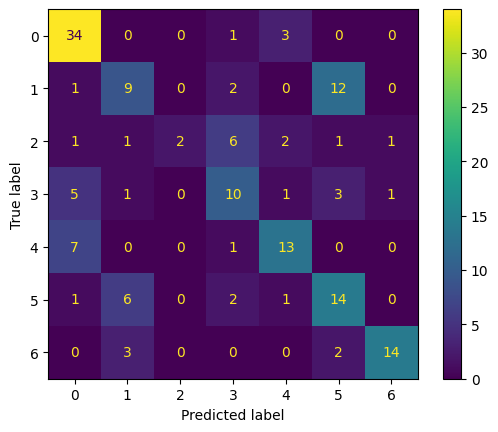


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['disgust(2)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [43]:
# compare with SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

Actually worse after feature selection. Featurewiz probably selected too few features. Let's also try our the ELM model with the most important features selected by featurewiz. 

In [142]:
# load most important 97 data from featurewiz selection
df_most_important97 = pd.read_pickle('../results/df_prep_most_important97.pkl')

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_most_important97, verbose=False, test_size=0.3)


Evaluation: f1_score
94.71% for the train data
73.52% for the test data

Evaluation: accuracy_score
94.39% for the train data
74.53% for the test data

Evaluation: precision_score
95.58% for the train data
75.77% for the test data

Evaluation: recall_score
94.09% for the train data
72.59% for the test data

Evaluation: confusion_matrix of test predictions


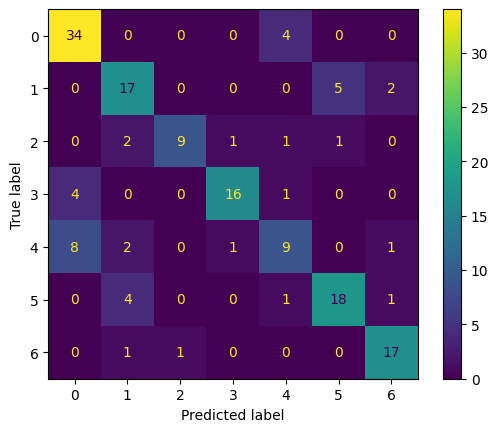


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [145]:
# run best model settings with these features again
elm = skelm.ELMClassifier(pairwise_metric='cosine', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)

## Feature Importance

RBF kernel. Computing permutation importance.


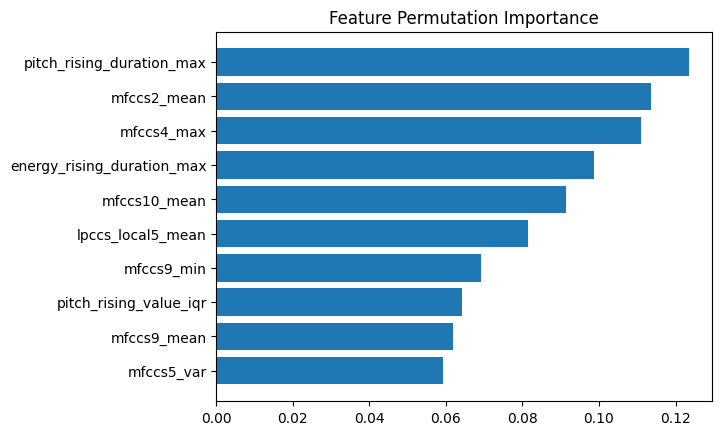

In [55]:
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced, verbose=False)
feature_importance(svm_model, X_test, y_test, top=10)

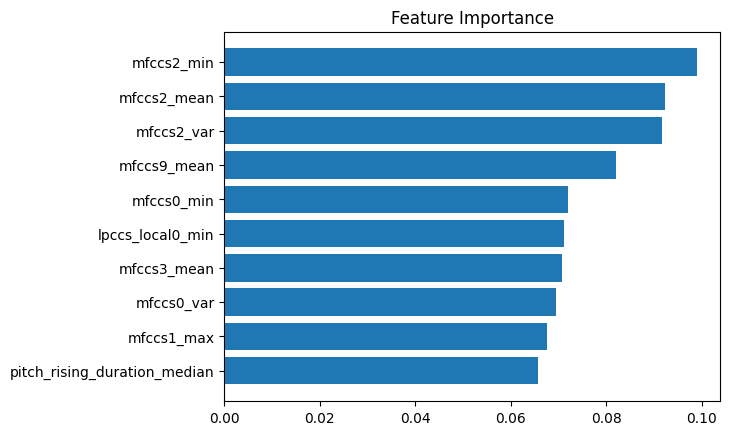

In [12]:
X_train, X_test, y_train, y_test = load_train_test_data(df_3_eplm, verbose=False)
feature_importance(svm_best_model_paper3, X_test, y_test, top=10)

RBF kernel. Computing permutation importance.


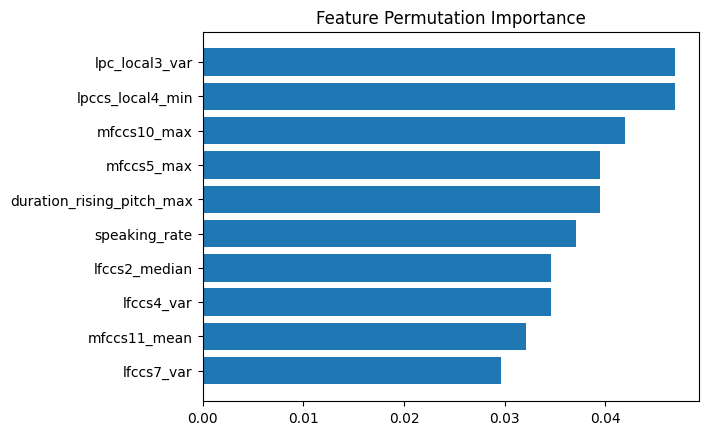

In [48]:
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced_all, verbose=False)
feature_importance(svm_model, X_test, y_test, top=10)

# Other Models
Besides the features and models from the papers, we also want to investigate other models and find an overall best combination of features and model with highest performance measured in F1 macro.

In [3]:
# load most important 97 data from featurewiz selection
df_most_important97 = pd.read_pickle('../results/df_prep_most_important97.pkl')

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_most_important97, verbose=False, test_size=0.3)

## Decision Tree


Evaluation: f1_score
100.00% for the train data
52.84% for the test data

Evaluation: accuracy_score
100.00% for the train data
53.42% for the test data

Evaluation: precision_score
100.00% for the train data
52.91% for the test data

Evaluation: recall_score
100.00% for the train data
53.59% for the test data

Evaluation: confusion_matrix of test predictions


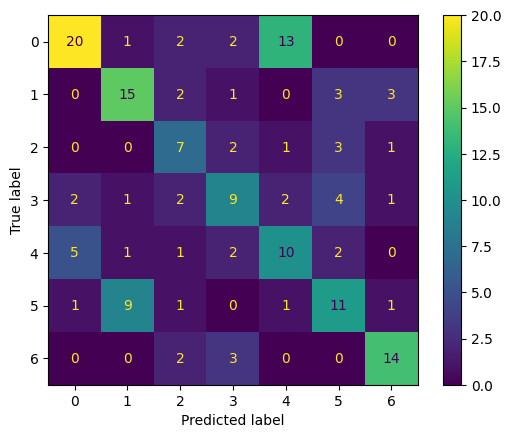


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [69]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)
model_eval(dtc, X_train, X_test, y_train, y_test, confusion=True)

 Number of leaves: 77
 Depth of the tree: 12
 General structure of the generated tree:



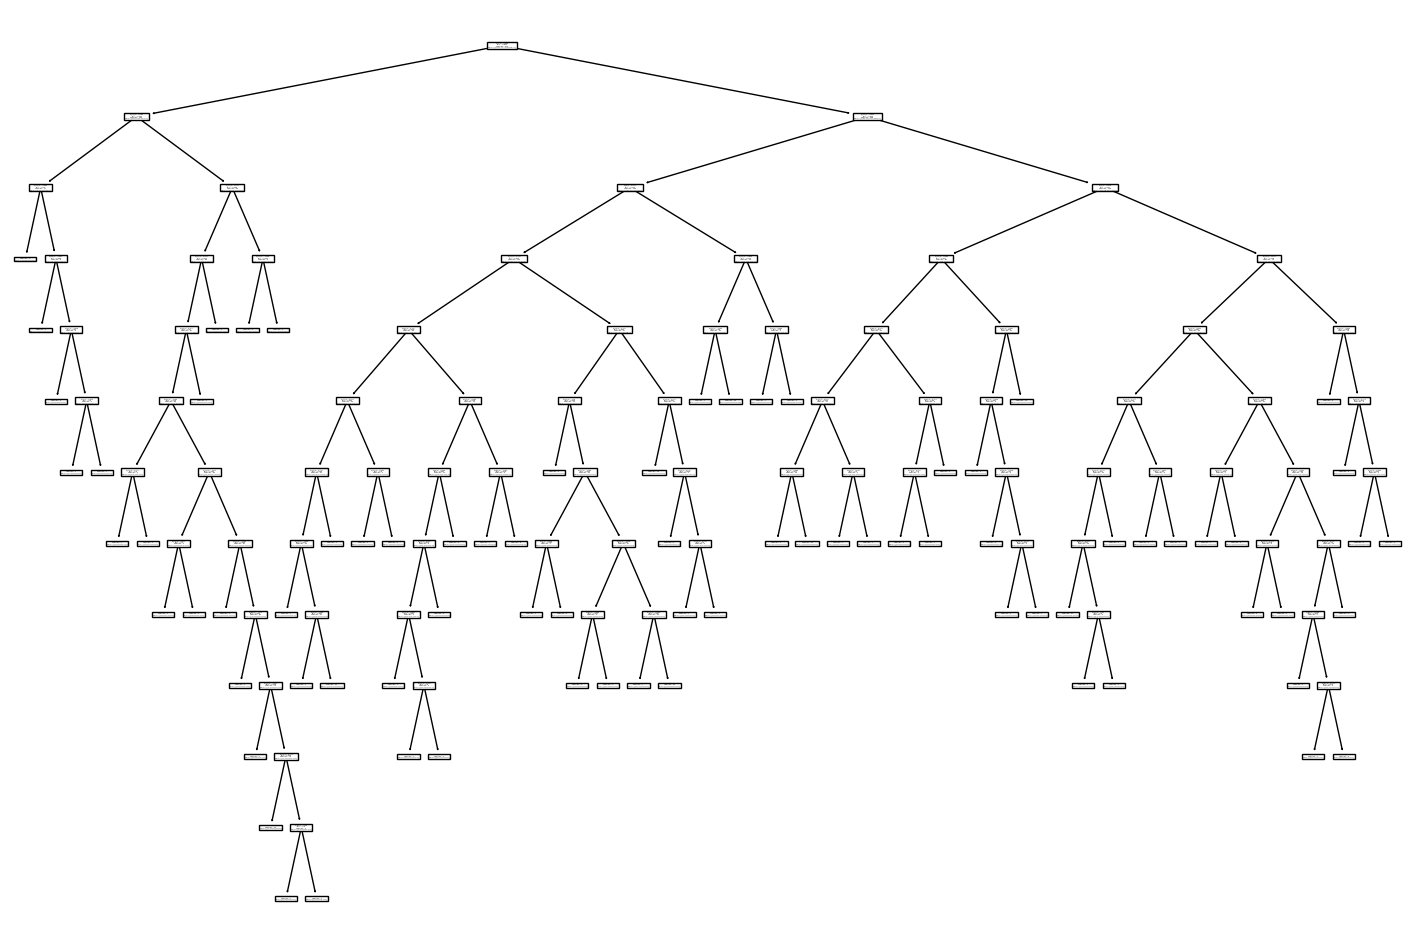

In [70]:
plt.figure(figsize=(18,12))
print(f' Number of leaves: {dtc.get_n_leaves()}\n Depth of the tree: {dtc.get_depth()}\n General structure of the generated tree:\n')
x = plot_tree(dtc)

As expected, the DecisionTreeClassifier is extremely overfitting. Let's see if a slight change of hyperparameters can improve this.

In [71]:
# define grid
decision_tree_grid = {'criterion' : ['gini', 'entropy'], 
                      'max_depth' : [5, 10, 20, 30]
                     }

In [72]:
run_gridsearchCV(dtc, decision_tree_grid, X_train, y_train, verbose=0)


Best hyperparameters : {'criterion': 'gini', 'max_depth': 5}
Best cross-validated f1_macro : 0.5173792494315348



Evaluation: f1_score
77.22% for the train data
55.53% for the test data

Evaluation: accuracy_score
78.61% for the train data
58.39% for the test data

Evaluation: precision_score
82.41% for the train data
57.82% for the test data

Evaluation: recall_score
75.62% for the train data
55.23% for the test data

Evaluation: confusion_matrix of test predictions


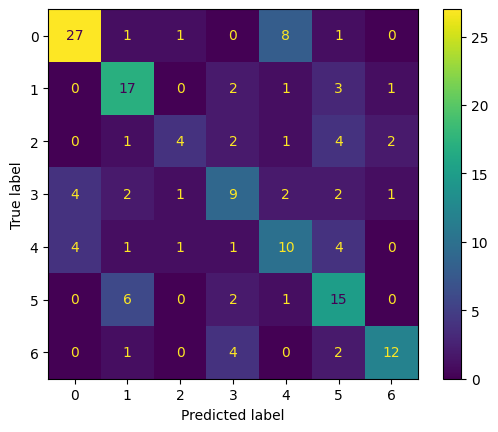


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['fear(3)']



In [73]:
# reload the best model & evaluate
dtc_best_model = load_model('DecisionTreeClassifier', 'f1_macro')
model_eval(dtc_best_model, X_train, X_test, y_train, y_test, confusion=True)

 Number of leaves: 25
 Depth of the tree: 5
 General structure of the generated tree:



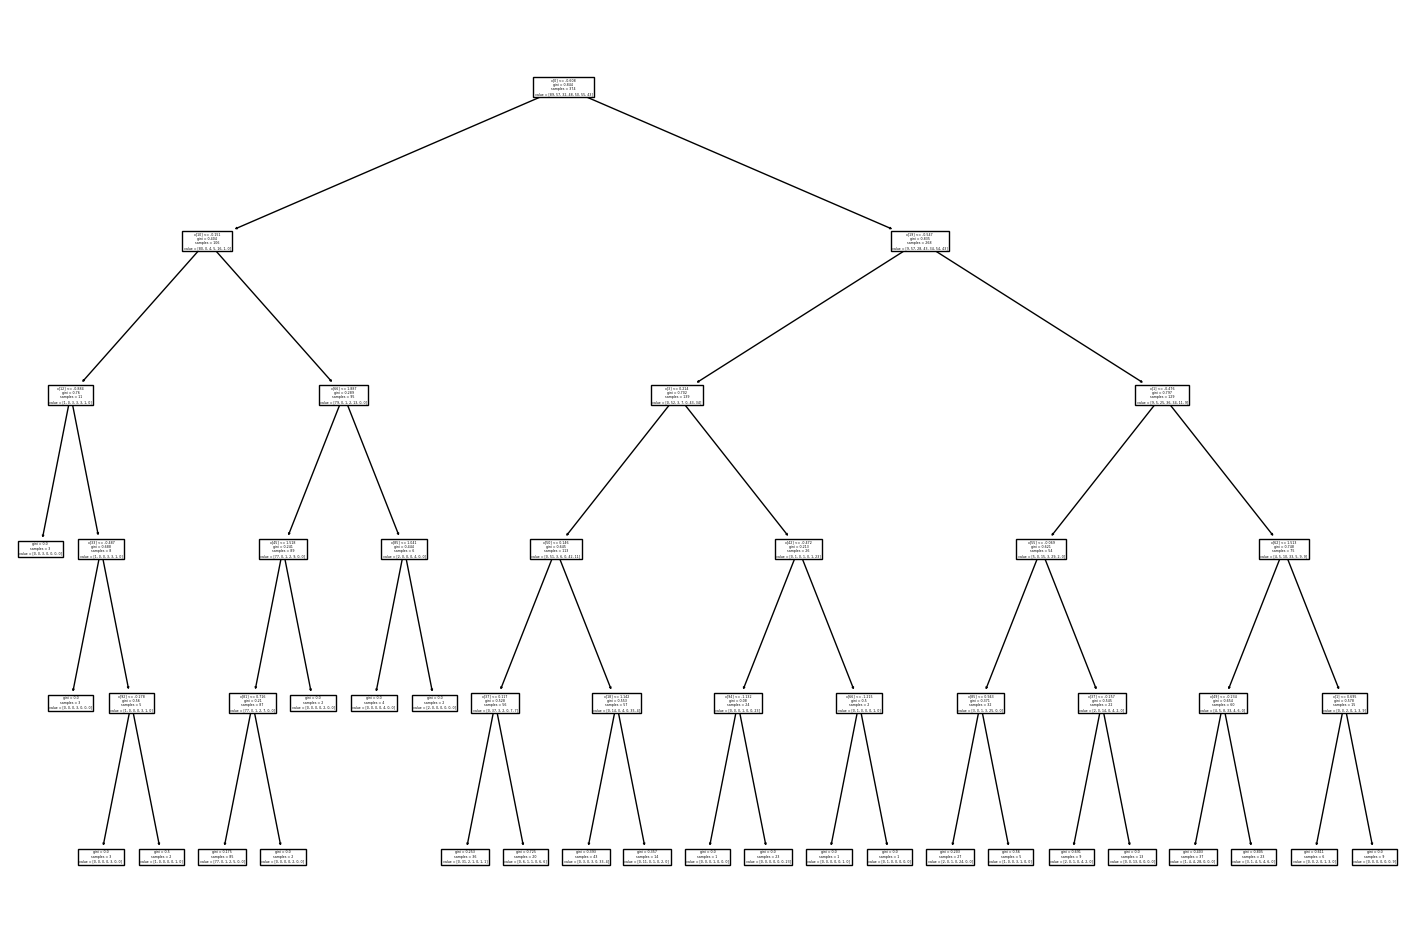

In [74]:
plt.figure(figsize=(18,12))
print(f' Number of leaves: {dtc_best_model.get_n_leaves()}\n Depth of the tree: {dtc_best_model.get_depth()}\n General structure of the generated tree:\n')
x = plot_tree(dtc_best_model)

Still bad generalization!

## Random Forest


Evaluation: f1_score
100.00% for the train data
71.08% for the test data

Evaluation: accuracy_score
100.00% for the train data
72.67% for the test data

Evaluation: precision_score
100.00% for the train data
74.45% for the test data

Evaluation: recall_score
100.00% for the train data
69.94% for the test data

Evaluation: confusion_matrix of test predictions


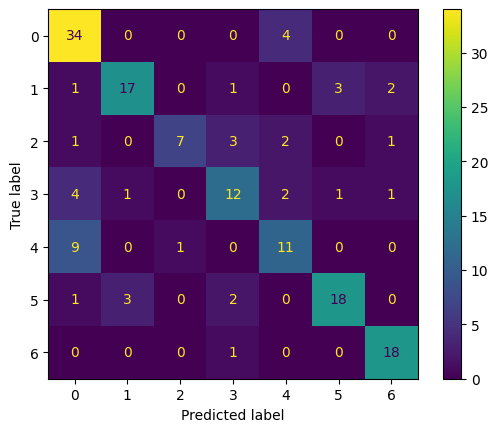


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']



In [75]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
model_eval(rfc, X_train, X_test, y_train, y_test, confusion=True)

In [76]:
# define grid
random_forest_grid = {'n_estimators': [5, 10, 100, 200],
                      'max_depth' : [5, 10, 20, 30],
                      'bootstrap': [True, False],
                      'warm_start': [True, False]
                     }

In [77]:
run_gridsearchCV(rfc, random_forest_grid, X_train, y_train, verbose=0)


Best hyperparameters : {'bootstrap': False, 'max_depth': 20, 'n_estimators': 200, 'warm_start': True}
Best cross-validated f1_macro : 0.7735604514033432



Evaluation: f1_score
100.00% for the train data
79.14% for the test data

Evaluation: accuracy_score
100.00% for the train data
79.50% for the test data

Evaluation: precision_score
100.00% for the train data
81.79% for the test data

Evaluation: recall_score
100.00% for the train data
78.02% for the test data

Evaluation: confusion_matrix of test predictions


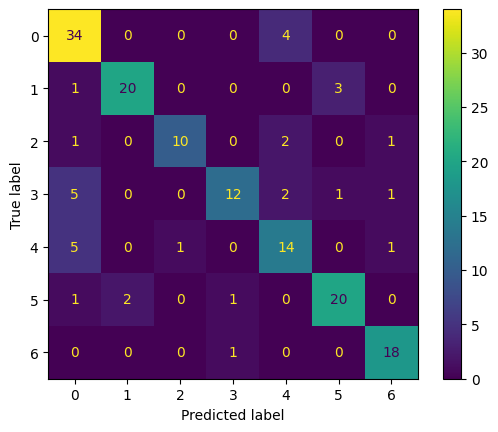


Hard cases for the model:

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [78]:
# reload the best model & evaluate
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro')
model_eval(rfc_best_model, X_train, X_test, y_train, y_test, confusion=True)

## KNN Classifier


Evaluation: f1_score
81.15% for the train data
64.47% for the test data

Evaluation: accuracy_score
81.55% for the train data
65.84% for the test data

Evaluation: precision_score
84.00% for the train data
66.36% for the test data

Evaluation: recall_score
80.15% for the train data
64.40% for the test data

Evaluation: confusion_matrix of test predictions


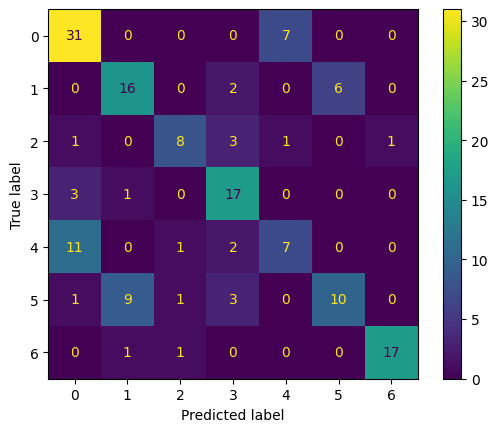


Hard cases for the model:

Label: anger(0)
Hard cases of false positives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [122]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
model_eval(knn, X_train, X_test, y_train, y_test, confusion=True)

In [85]:
# define grid
knn_grid = {'n_neighbors': [3, 4, 5, 6, 7, 8],
           'weights': ['uniform', 'distance'],
           }

In [86]:
run_gridsearchCV(knn, knn_grid, X_train, y_train, verbose=0)


Best hyperparameters : {'n_neighbors': 7, 'weights': 'distance'}
Best cross-validated f1_macro : 0.6741918202773153



Evaluation: f1_score
100.00% for the train data
63.71% for the test data

Evaluation: accuracy_score
100.00% for the train data
64.60% for the test data

Evaluation: precision_score
100.00% for the train data
66.14% for the test data

Evaluation: recall_score
100.00% for the train data
63.60% for the test data

Evaluation: confusion_matrix of test predictions


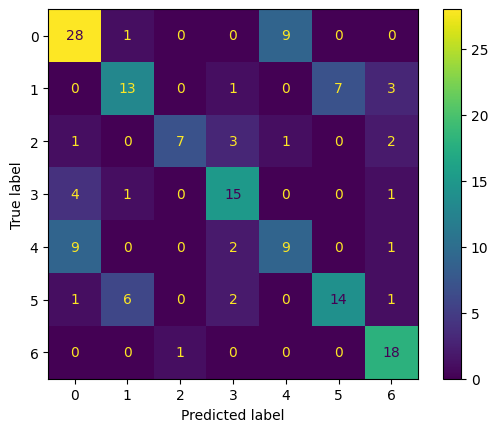


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']
Hard cases of false positives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [87]:
# reload the best model & evaluate
knn_best_model = load_model('KNeighborsClassifier', 'f1_macro')
model_eval(knn_best_model, X_train, X_test, y_train, y_test, confusion=True)

## Naive Bayes

In [105]:
# first check if data follows a normal distribution
from scipy.stats import shapiro

looks_gaussian = []
doesntlook_gaussian = []

for feature in X_train.columns:
    stat, p = shapiro(X_train[feature])
    #print('Feature {}: Statistics = {}, p = {}'.format(feature, stat, p))
    alpha = 0.05
    if p > alpha:
        looks_gaussian.append(feature)
    else:
        doesntlook_gaussian.append(feature)

print('Feature that look Gaussian:\n{}\n'.format(looks_gaussian))
print('Feature that do not look Gaussian:\n{}'.format(doesntlook_gaussian))

Feature that look Gaussian:
['zcr_max', 'lpc_local1_mean', 'f2_mean', 'mfccs4_max', 'lpc_local4_median', 'lfccs6_mean', 'speaking_rate', 'amplitude_avg_change_rate_min', 'f2_avg_change_rate_max', 'lpc_global_median', 'threshold_entropy_mean', 'lfccs4_median', 'mfccs5_max', 'lfccs3_median', 'lfccs11_mean', 'lfccs8_mean', 'lfccs10_median']

Feature that do not look Gaussian:
['rms_min', 'mfccs5_mean', 'duration_rising_pitch_max', 'lpccs_local4_min', 'lfccs9_max', 'min', 'energy_median', 'lfccs0_median', 'lpccs_global_median', 'lpc_global_mean', 'value_falling_energy_max', 'mfccs11_mean', 'f1_min', 'lpc_local3_var', 'lpccs_local0_var', 'f0_avg_change_rate_median', 'lfccs9_median', 'delta_mfccs0_min', 'value_falling_pitch_iqr', 'f1_avg_change_rate_var', 'threshold_entropy_var', 'mfccs3_max', 'lfccs7_var', 'lfccs9_var', 'delta_mfccs5_median', 'energy_var', 'delta2_mfccs3_min', 'lpccs_local5_mean', 'shannon_entropy_mean', 'delta2_mfccs5_mean', 'delta_mfccs4_median', 'f3_mean', 'mfccs5_var', 


Evaluation: f1_score
83.53% for the train data
70.95% for the test data

Evaluation: accuracy_score
83.69% for the train data
70.81% for the test data

Evaluation: precision_score
83.02% for the train data
72.97% for the test data

Evaluation: recall_score
84.61% for the train data
70.72% for the test data

Evaluation: confusion_matrix of test predictions


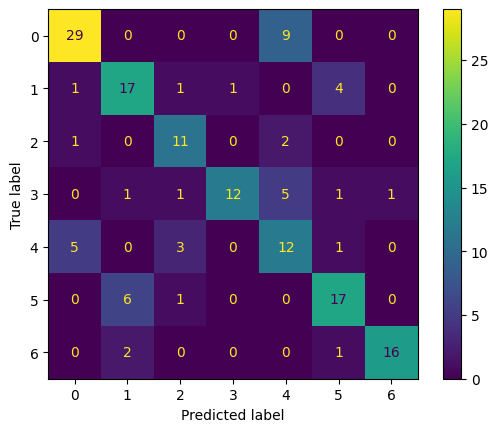


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [123]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
model_eval(gnb, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
75.41% for the train data
74.31% for the test data

Evaluation: accuracy_score
76.20% for the train data
73.29% for the test data

Evaluation: precision_score
75.53% for the train data
75.46% for the test data

Evaluation: recall_score
75.53% for the train data
74.35% for the test data

Evaluation: confusion_matrix of test predictions


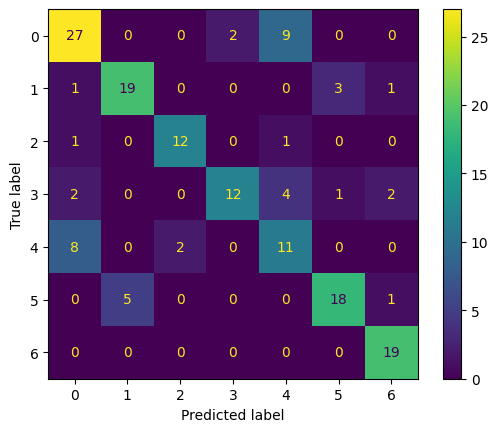


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']
Hard cases of false positives: ['happiness(4)']

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [124]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
model_eval(bnb, X_train, X_test, y_train, y_test, confusion=True)

## XGBoost Classifier


Evaluation: f1_score
100.00% for the train data
73.35% for the test data

Evaluation: accuracy_score
100.00% for the train data
73.29% for the test data

Evaluation: precision_score
100.00% for the train data
73.09% for the test data

Evaluation: recall_score
100.00% for the train data
74.39% for the test data

Evaluation: confusion_matrix of test predictions


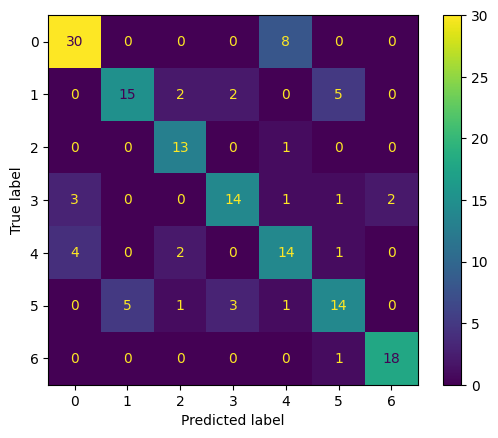


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [4]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)
model_eval(xgb, X_train, X_test, y_train, y_test, confusion=True)

In [7]:
# define grid
xgb_grid = {'n_estimators': [5, 10, 100, 200, 250, 300],
            'max_depth' : [2, 5, 10, 20, 30],
            'learning_rate': [0.001, 0.01, 0.1, 0.5]
           }

In [138]:
run_gridsearchCV(xgb, xgb_grid, X_train, y_train, verbose=0)


Best hyperparameters : {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 250}
Best cross-validated f1_macro : 0.7581574518523653



Evaluation: f1_score
100.00% for the train data
80.31% for the test data

Evaluation: accuracy_score
100.00% for the train data
80.12% for the test data

Evaluation: precision_score
100.00% for the train data
80.96% for the test data

Evaluation: recall_score
100.00% for the train data
80.03% for the test data

Evaluation: confusion_matrix of test predictions


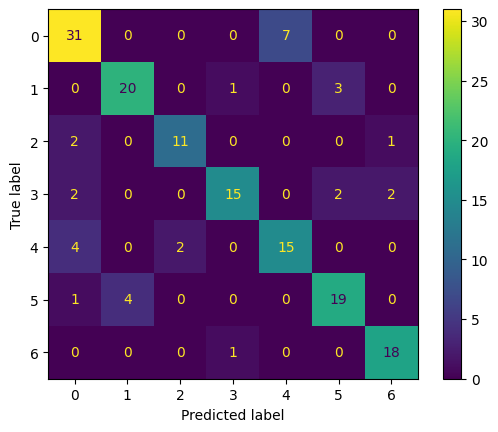


Hard cases for the model:

Label: happiness(4)
Hard cases of false positives: ['anger(0)']



In [139]:
# reload the best model & evaluate
xgb_best_model = load_model('XGBClassifier', 'f1_macro')
model_eval(xgb_best_model, X_train, X_test, y_train, y_test, confusion=True)

From all of these traditional models, Random Forest and XGB Classifier show best performance. Hence, let's also run the models with all numerical features we created and also try out it's performance with PCA.
### a) With all numerical features

In [5]:
# load the data iwth all numerical features
df_all_stats = pd.read_pickle('../results/df_prep_numerical_only_all_stats.pkl')

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_all_stats, verbose=False, test_size=0.3)

#### Random Forest 

In [118]:
run_gridsearchCV(rfc, random_forest_grid, X_train, y_train, verbose=0, name_spec='with_all_stats')


Best hyperparameters : {'bootstrap': False, 'max_depth': 10, 'n_estimators': 200, 'warm_start': True}
Best cross-validated f1_macro : 0.7387847399226148



Evaluation: f1_score
100.00% for the train data
77.66% for the test data

Evaluation: accuracy_score
100.00% for the train data
78.88% for the test data

Evaluation: precision_score
100.00% for the train data
80.03% for the test data

Evaluation: recall_score
100.00% for the train data
76.81% for the test data

Evaluation: confusion_matrix of test predictions


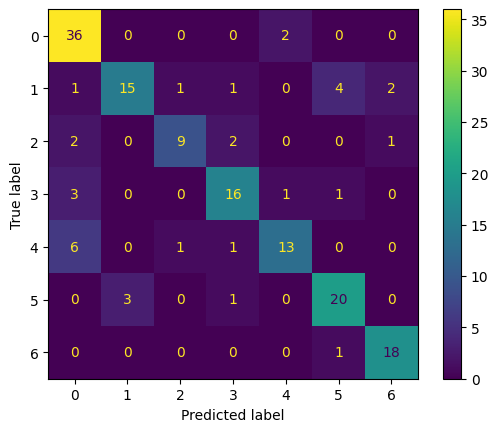


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [119]:
# reload the best model & evaluate
rfc_best_model_all_stats = load_model('RandomForestClassifier', 'f1_macro', name_spec='with_all_stats')
model_eval(rfc_best_model_all_stats, X_train, X_test, y_train, y_test, confusion=True)

#### XGB Classifier

In [8]:
run_gridsearchCV(xgb, xgb_grid, X_train, y_train, verbose=0, name_spec='with_all_stats')


Best hyperparameters : {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 100}
Best cross-validated f1_macro : 0.755863745042254



Evaluation: f1_score
100.00% for the train data
80.49% for the test data

Evaluation: accuracy_score
100.00% for the train data
80.75% for the test data

Evaluation: precision_score
100.00% for the train data
81.72% for the test data

Evaluation: recall_score
100.00% for the train data
79.89% for the test data

Evaluation: confusion_matrix of test predictions


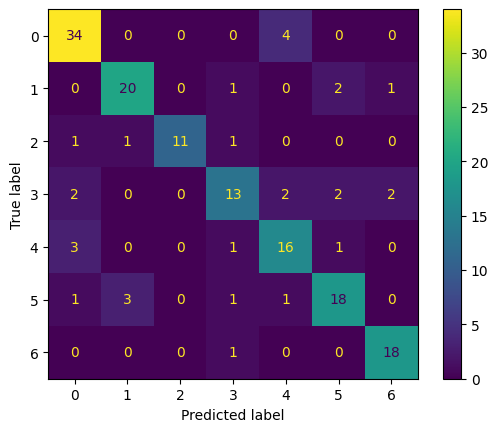


Hard cases for the model:



In [9]:
# reload the best model & evaluate
xgb_best_model_all_stats = load_model('XGBClassifier', 'f1_macro', name_spec='with_all_stats')
model_eval(xgb_best_model_all_stats, X_train, X_test, y_train, y_test, confusion=True)

### b) with PCA

In [11]:
pca = PCA(0.9)
principalComponents = pca.fit_transform(df_all_stats.drop('label', axis=1))

principal_df = pd.DataFrame(data = principalComponents)
principal_df = pd.concat([principal_df, df_all_stats[['label']]], axis = 1)

print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

103
[0.1371097  0.1225378  0.04878109 0.04306813 0.03503977 0.03143388
 0.02841167 0.02122009 0.01921022 0.01644826 0.01569456 0.01476704
 0.01442153 0.01311755 0.01305086 0.01188505 0.01135937 0.01061576
 0.01011364 0.00922488 0.00884234 0.00823372 0.00770304 0.00751619
 0.0071806  0.00701369 0.00693512 0.00659679 0.00637725 0.00610694
 0.00588616 0.00584404 0.00550799 0.00536687 0.00504853 0.00482218
 0.00472164 0.00452798 0.00438488 0.00430476 0.00414801 0.00408645
 0.0040593  0.00381127 0.00378764 0.00361238 0.00355297 0.00350895
 0.00345933 0.00336829 0.00329617 0.00314747 0.00311828 0.00304889
 0.0029914  0.00296533 0.00284535 0.0028187  0.00276443 0.0027123
 0.00267024 0.00261958 0.00260387 0.00251982 0.00244606 0.00243382
 0.0023608  0.00232406 0.00227299 0.00225475 0.00222684 0.00218453
 0.0021589  0.00212355 0.00208363 0.00205167 0.00204371 0.00196448
 0.00195309 0.00193649 0.00193473 0.00188694 0.00186865 0.00183865
 0.00183572 0.00179142 0.00176027 0.00173093 0.00172303 0.0

In [12]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False, test_size=0.3)

#### Random Forest

In [127]:
run_gridsearchCV(rfc, random_forest_grid, X_train, y_train, verbose=0, name_spec='with_pca')


Best hyperparameters : {'bootstrap': False, 'max_depth': 20, 'n_estimators': 200, 'warm_start': True}
Best cross-validated f1_macro : 0.6476876795780924



Evaluation: f1_score
100.00% for the train data
71.50% for the test data

Evaluation: accuracy_score
100.00% for the train data
72.05% for the test data

Evaluation: precision_score
100.00% for the train data
78.06% for the test data

Evaluation: recall_score
100.00% for the train data
69.88% for the test data

Evaluation: confusion_matrix of test predictions


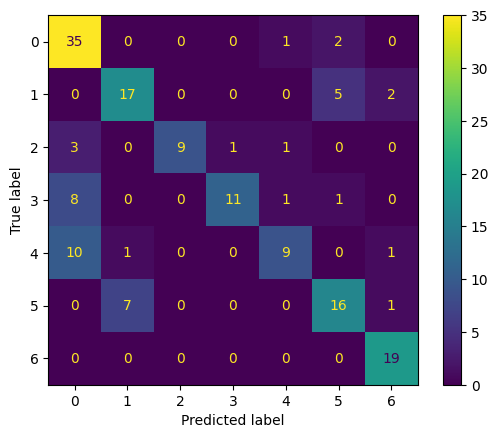


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [129]:
# reload the best model & evaluate
rfc_best_model_pca = load_model('RandomForestClassifier', 'f1_macro', name_spec='with_pca')
model_eval(rfc_best_model_pca, X_train, X_test, y_train, y_test, confusion=True)

#### XGB Classifier

In [13]:
run_gridsearchCV(xgb, xgb_grid, X_train, y_train, verbose=0, name_spec='with_pca')


Best hyperparameters : {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 200}
Best cross-validated f1_macro : 0.6957647659387592



Evaluation: f1_score
100.00% for the train data
70.55% for the test data

Evaluation: accuracy_score
100.00% for the train data
70.81% for the test data

Evaluation: precision_score
100.00% for the train data
73.64% for the test data

Evaluation: recall_score
100.00% for the train data
69.18% for the test data

Evaluation: confusion_matrix of test predictions


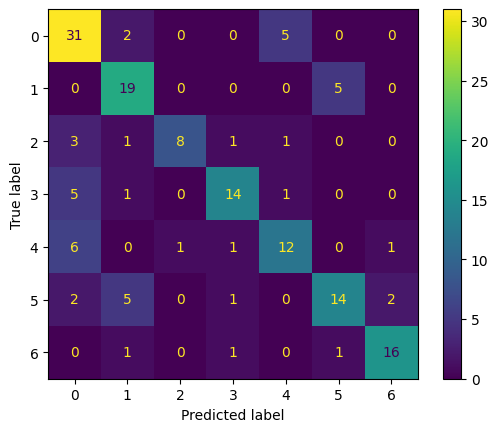


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [14]:
# reload the best model & evaluate
xgb_best_model_pca = load_model('XGBClassifier', 'f1_macro', name_spec='with_pca')
model_eval(xgb_best_model_pca, X_train, X_test, y_train, y_test, confusion=True)

## Feature Importance for other models
Models perform best with featurewiz 97 data set. Let's look at the feature importances within the different models on that data set.

In [2]:
# load most important 97 data from featurewiz selection
df_most_important97 = pd.read_pickle('../results/df_prep_most_important97.pkl')

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_most_important97, verbose=False, test_size=0.3)

RBF kernel. Computing permutation importance.


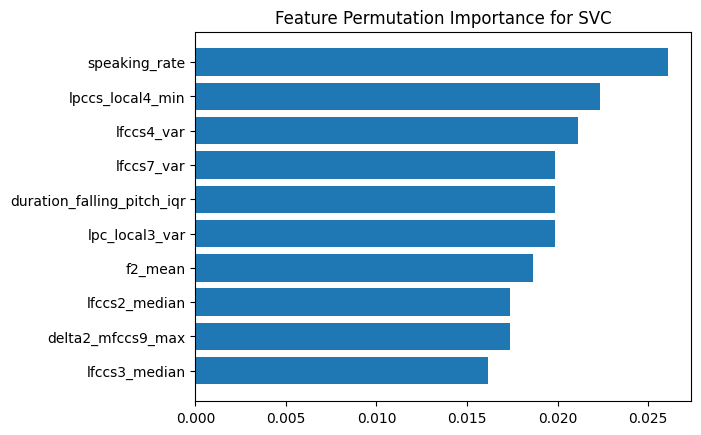

In [4]:
svm_best_model = load_model('SVC', 'f1_macro', name_spec='most_important97') # load model
feature_importance(svm_best_model, X_test, y_test, top=10)

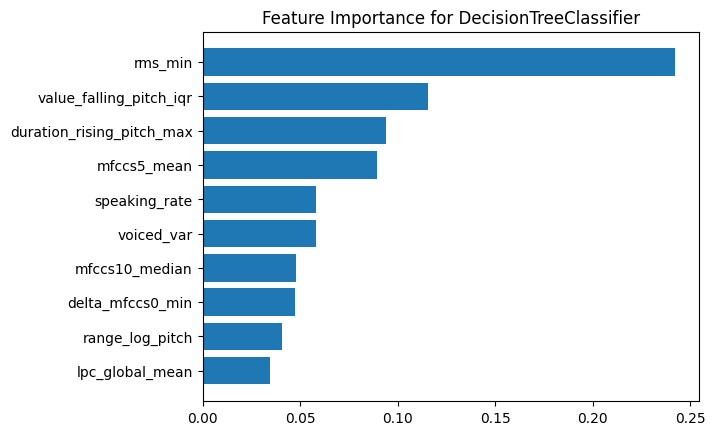

In [5]:
dtc_best_model = load_model('DecisionTreeClassifier', 'f1_macro') # load model
feature_importance(dtc_best_model, X_test, y_test, top=10)

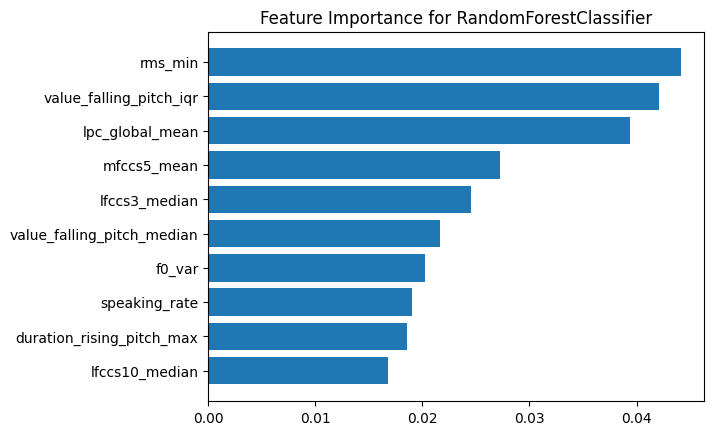

In [6]:
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro') # load model
feature_importance(rfc_best_model, X_test, y_test, top=10)

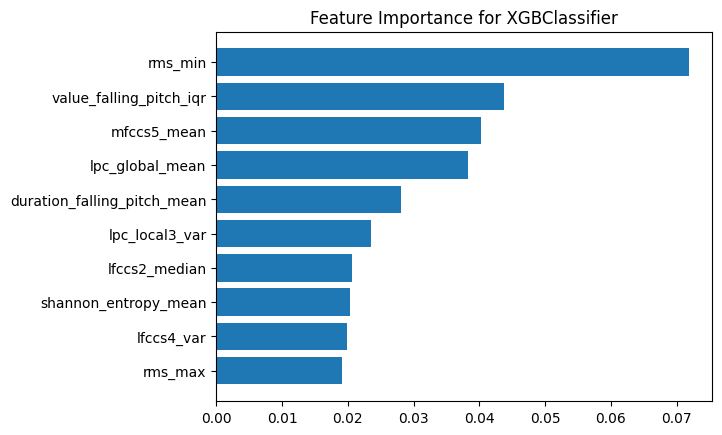

In [7]:
xgb_best_model = load_model('XGBClassifier', 'f1_macro') # load model
feature_importance(xgb_best_model, X_test, y_test, top=10)